In [ ]:
!pip install alpaca-trade-api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.7/757.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 10.6 MB/s eta 0:00:00
  Created wheel for msgpack: filename=msgpack-1.0.3-cp311-cp311-linux_x86_64.whl size=15688 sha256=48d6d3879a00cba38da3e74ed5d7b188da60931e506723046fbeb074832fdd4a
  Stored in directory: /root/.cache/pip/wheels/f6/35/da/ed9b26b510235e00e3a3c3bab7bad97b59214729662255ab3d
Successfully built msgpack
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.1.1
    Uninstalling msgpack-1.1.1:
      Successfully uninstalled msgpack-1.1.1
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstallin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

In [ ]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from zoneinfo import ZoneInfo


In [ ]:
df_NVDA_1min = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/WS_Bulls/NVDA_1min_2021_2025.csv')
df_NVDA_2min = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/WS_Bulls/NVDA_2min_2021_2025.csv')

In [ ]:
print(df_NVDA_1min.shape)
print(df_NVDA_2min.shape)
print(df_NVDA_1min.columns)
print(df_NVDA_2min.columns)
print(df_NVDA_1min.isnull().sum)
print(df_NVDA_2min.isnull().sum)

(800395, 8)
(431664, 8)
Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'trade_count',
       'vwap'],
      dtype='object')
Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'trade_count',
       'vwap'],
      dtype='object')
<bound method DataFrame.sum of         timestamp   open   high    low  close  volume  trade_count   vwap
0           False  False  False  False  False   False        False  False
1           False  False  False  False  False   False        False  False
2           False  False  False  False  False   False        False  False
3           False  False  False  False  False   False        False  False
4           False  False  False  False  False   False        False  False
...           ...    ...    ...    ...    ...     ...          ...    ...
800390      False  False  False  False  False   False        False  False
800391      False  False  False  False  False   False        False  False
800392      False  False  False  False  False   F

In [ ]:
# Ensure timestamp is datetime
df_NVDA_1min['timestamp'] = pd.to_datetime(df_NVDA_1min['timestamp'])
df_NVDA_2min['timestamp'] = pd.to_datetime(df_NVDA_2min['timestamp'])

# Convert to US/Eastern timezone
df_NVDA_1min['timestamp'] = df_NVDA_1min['timestamp'].dt.tz_convert(ZoneInfo("America/New_York"))
df_NVDA_2min['timestamp'] = df_NVDA_2min['timestamp'].dt.tz_convert(ZoneInfo("America/New_York"))

t_split1 = pd.Timestamp('2021-07-20', tz=ZoneInfo("America/New_York"))
t_split2 = pd.Timestamp('2024-06-10', tz=ZoneInfo("America/New_York"))

# Combined split factors
price_cols = ['open', 'high', 'low', 'close', 'vwap']

# --- Before first split: needs both 4x and 10x adjustment = 40x ---
mask_1min_40 = df_NVDA_1min['timestamp'] < t_split1
df_NVDA_1min.loc[mask_1min_40, price_cols] /= 40
df_NVDA_1min.loc[mask_1min_40, 'volume'] *= 40

# --- Between first and second split: needs only 10x adjustment ---
mask_1min_10 = (df_NVDA_1min['timestamp'] >= t_split1) & (df_NVDA_1min['timestamp'] < t_split2)
df_NVDA_1min.loc[mask_1min_10, price_cols] /= 10
df_NVDA_1min.loc[mask_1min_10, 'volume'] *= 10

mask_2min_40 = df_NVDA_2min['timestamp'] < t_split1
df_NVDA_2min.loc[mask_2min_40, price_cols] /= 40
df_NVDA_2min.loc[mask_2min_40, 'volume'] *= 40

mask_2min_10 = (df_NVDA_2min['timestamp'] >= t_split1) & (df_NVDA_2min['timestamp'] < t_split2)
df_NVDA_2min.loc[mask_2min_10, price_cols] /= 10
df_NVDA_2min.loc[mask_2min_10, 'volume'] *= 10


In [ ]:
# Extract features (without setting index)
for df in [df_NVDA_1min, df_NVDA_2min]:
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['day'] = df['timestamp'].dt.day
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    df['dayofweek'] = df['timestamp'].dt.dayofweek  # Monday = 0

In [ ]:
# Filter and print heads for each DataFrame
df_NVDA_1min_filtered = df_NVDA_1min[
    (df_NVDA_1min['dayofweek'] < 5) &
    ((df_NVDA_1min['hour'] > 9) | ((df_NVDA_1min['hour'] == 9) & (df_NVDA_1min['minute'] >= 30))) &
    ((df_NVDA_1min['hour'] < 16) | ((df_NVDA_1min['hour'] == 16) & (df_NVDA_1min['minute'] <= 30)))
]

df_NVDA_2min_filtered = df_NVDA_2min[
    (df_NVDA_2min['dayofweek'] < 5) &
    ((df_NVDA_2min['hour'] > 9) | ((df_NVDA_2min['hour'] == 9) & (df_NVDA_2min['minute'] >= 30))) &
    ((df_NVDA_2min['hour'] < 16) | ((df_NVDA_2min['hour'] == 16) & (df_NVDA_2min['minute'] <= 30)))
]

# Show heads
print("1-Minute Data Sample:")
print(df_NVDA_1min_filtered.head())

print("\n2-Minute Data Sample:")
print(df_NVDA_2min_filtered.head())

1-Minute Data Sample:
                   timestamp       open       high        low      close  \
80 2021-01-04 09:30:00-05:00  13.104250  13.105030  12.974750  12.978250   
81 2021-01-04 09:31:00-05:00  12.964462  13.054997  12.964462  13.010250   
82 2021-01-04 09:32:00-05:00  13.003750  13.035000  12.975000  12.990000   
83 2021-01-04 09:33:00-05:00  12.982747  12.997750  12.962500  12.997750   
84 2021-01-04 09:34:00-05:00  12.997000  13.028000  12.975625  13.006852   

        volume  trade_count       vwap  year  month  day  hour  minute  \
80  12538400.0       2946.0  13.079408  2021      1    4     9      30   
81   1518640.0       1000.0  13.020834  2021      1    4     9      31   
82   1200680.0        779.0  13.003002  2021      1    4     9      32   
83   1516240.0        946.0  12.978636  2021      1    4     9      33   
84   1351600.0        809.0  13.001160  2021      1    4     9      34   

    dayofweek  
80          0  
81          0  
82          0  
83          

In [ ]:
# Keep only rows where minute is odd
df_NVDA_1min_filtered_odd = df_NVDA_1min_filtered[df_NVDA_1min_filtered['minute'] % 2 == 1]

# Preview the result
df_NVDA_1min_filtered_odd.head()

timestamp       open       high        low     close  \
81 2021-01-04 09:31:00-05:00  12.964462  13.054997  12.964462  13.01025   
83 2021-01-04 09:33:00-05:00  12.982747  12.997750  12.962500  12.99775   
85 2021-01-04 09:35:00-05:00  13.006250  13.040000  12.998375  13.03200   
87 2021-01-04 09:37:00-05:00  13.008000  13.021100  13.001250  13.00450   
89 2021-01-04 09:39:00-05:00  13.042375  13.059250  13.029982  13.03400   

       volume  trade_count       vwap  year  month  day  hour  minute  \
81  1518640.0       1000.0  13.020834  2021      1    4     9      31   
83  1516240.0        946.0  12.978636  2021      1    4     9      33   
85  1213480.0        822.0  13.014610  2021      1    4     9      35   
87  1367320.0        777.0  13.007973  2021      1    4     9      37   
89  1297240.0        581.0  13.045253  2021      1    4     9      39   

    dayofweek  
81          0  
83          0  
85          0  
87          0  
89          0

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


 Running EDA for NVDA 1-Min Odd
 Shape: (216036, 36)

 Data types:
 open                       float64
high                       float64
low                        float64
close                      float64
volume                     float64
trade_count                float64
vwap                       float64
year                         int32
month                        int32
day                          int32
hour                         int32
minute                       int32
dayofweek                    int32
ma_5                       float64
ma_10                      float64
ma_20                      float64
buy_volume                 float64
sell_volume                float64
date                        object
price_change               float64
volume_change              float64
strong_uptrend               int64
strong_downtrend             int64
weak_momentum                int64
potential_reversal           int64
vwap_spread                float64
price_to_vwap_ratio  

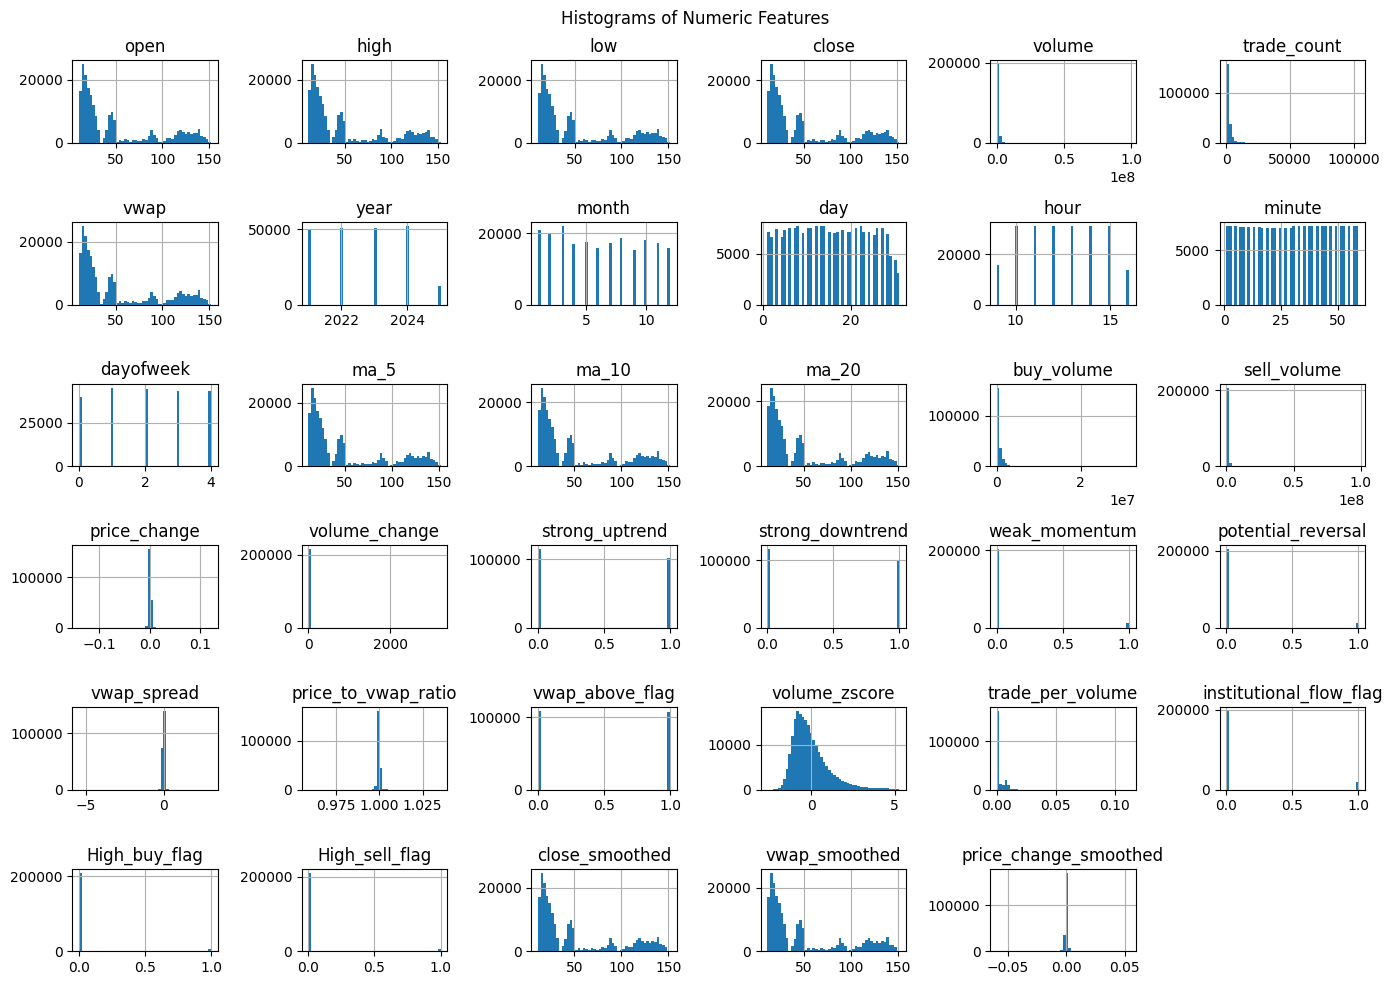

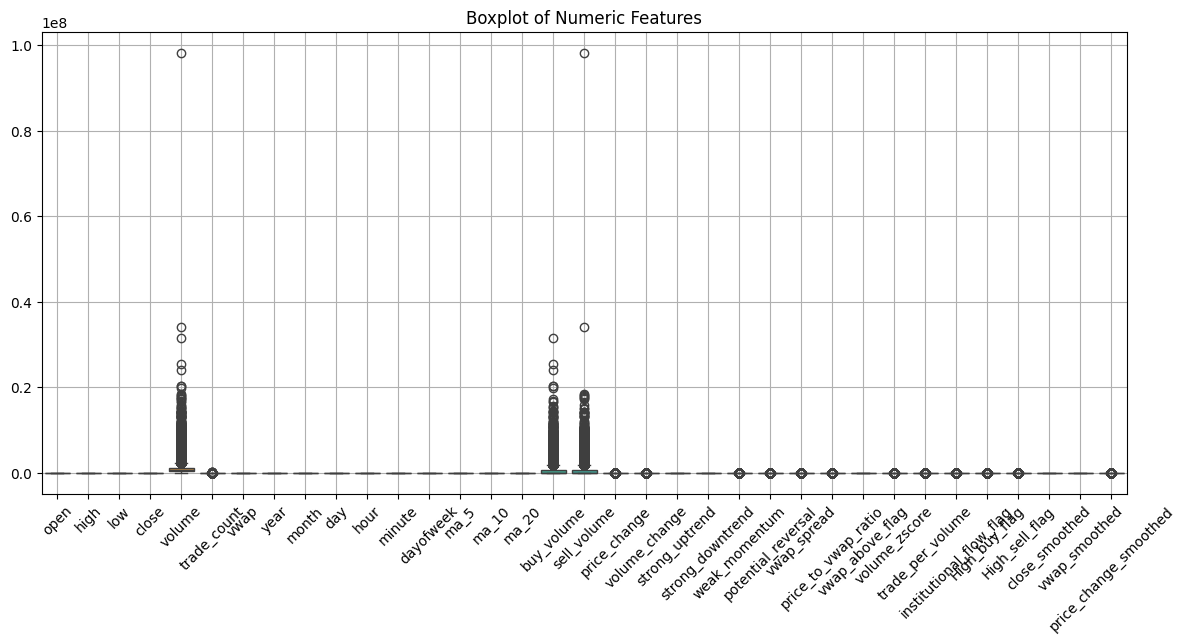

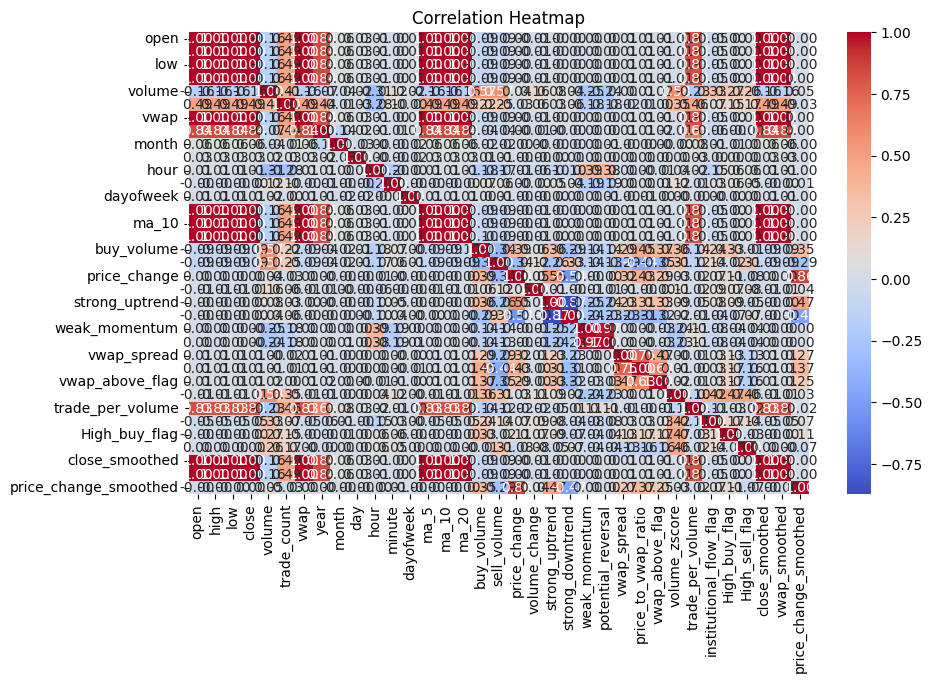


 Feature Engineering Suggestions:
- Consider rolling mean or volatility indicators.
- Add RSI, MACD, moving averages, or candlestick patterns.
- Extract temporal features like market open windows.
- Normalize or scale volume / trade_count if skewed.


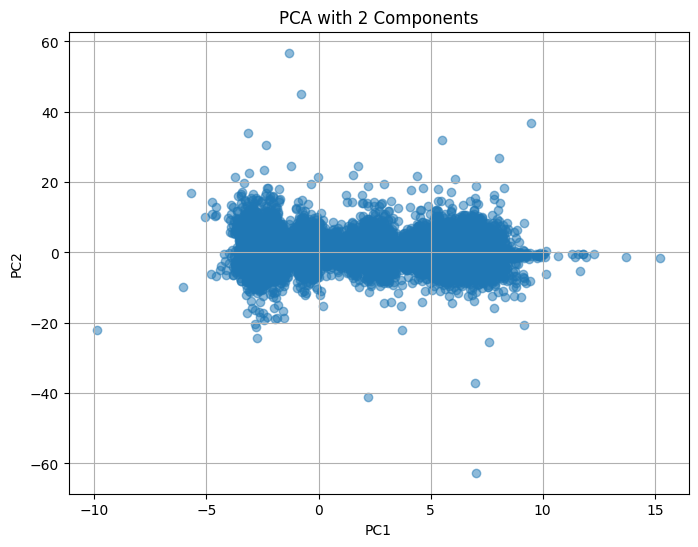


 Running EDA for NVDA 2-Min All
 Shape: (218053, 31)

 Data types:
 open                         float64
high                         float64
low                          float64
close                        float64
volume                       float64
trade_count                  float64
vwap                         float64
year                           int32
month                          int32
day                            int32
hour                           int32
minute                         int32
dayofweek                      int32
price_change                 float64
volume_change                float64
strong_uptrend               float64
strong_downtrend               int64
weak_momentum                  int64
potential_reversal             int64
vwap_spread                  float64
price_to_vwap_ratio          float64
vwap_above_flag                int64
volume_zscore_2              float64
trade_per_volume             float64
institutional_flow_flag_2      int64
volume

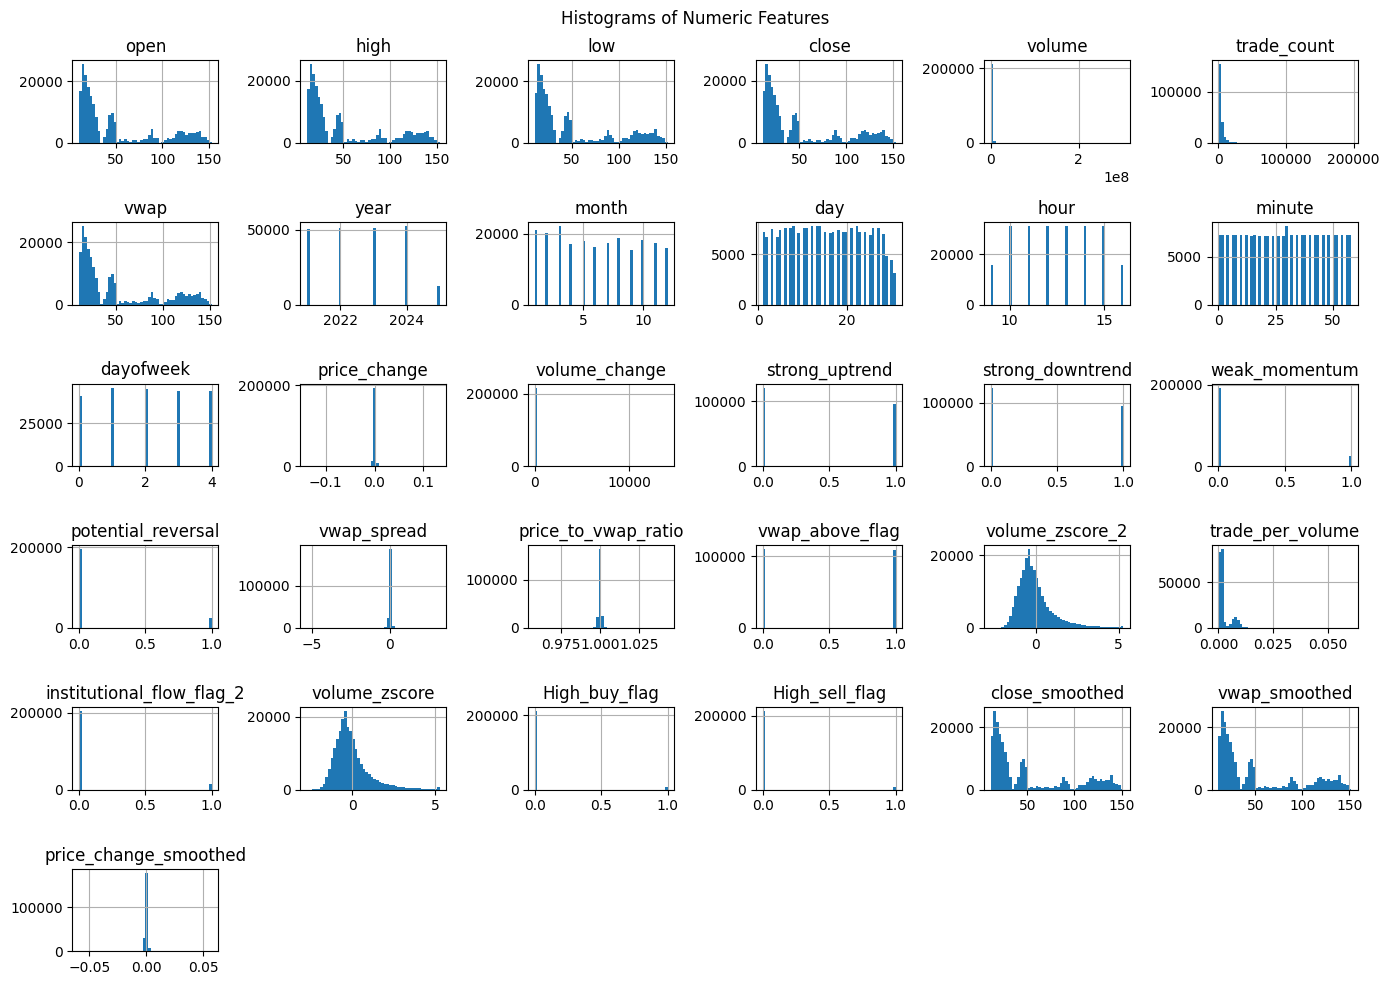

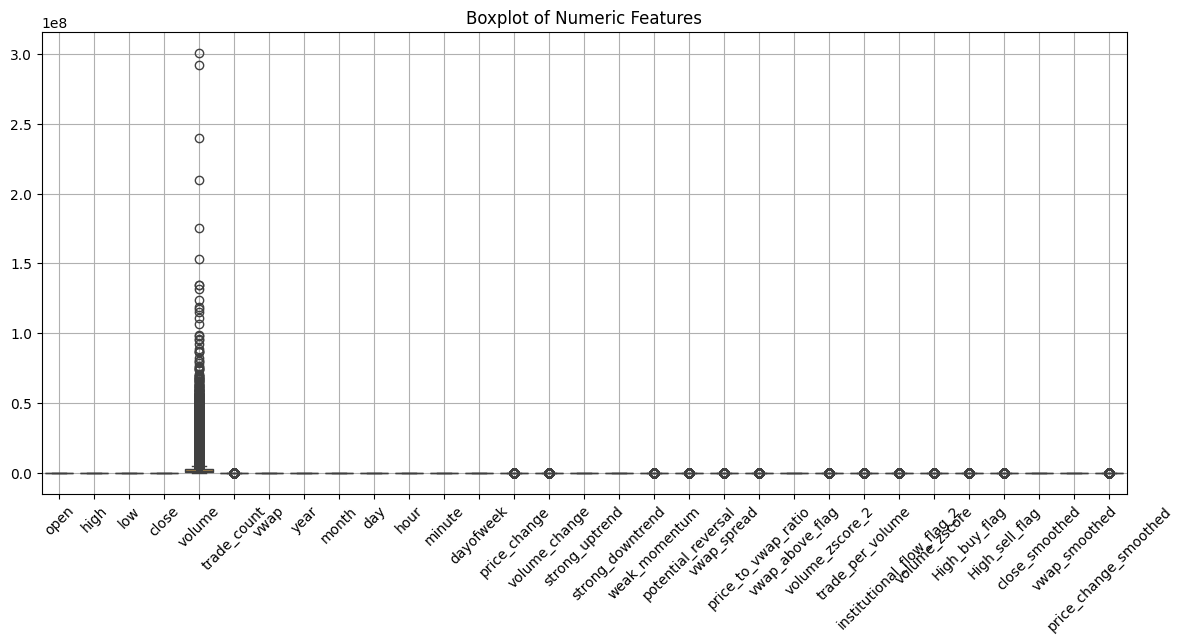

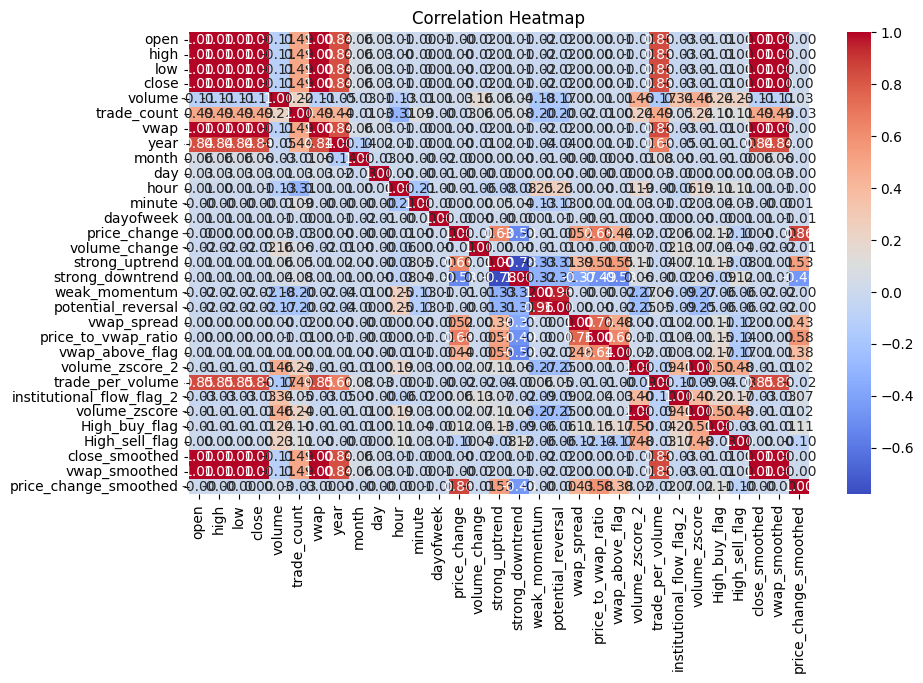


 Feature Engineering Suggestions:
- Consider rolling mean or volatility indicators.
- Add RSI, MACD, moving averages, or candlestick patterns.
- Extract temporal features like market open windows.
- Normalize or scale volume / trade_count if skewed.


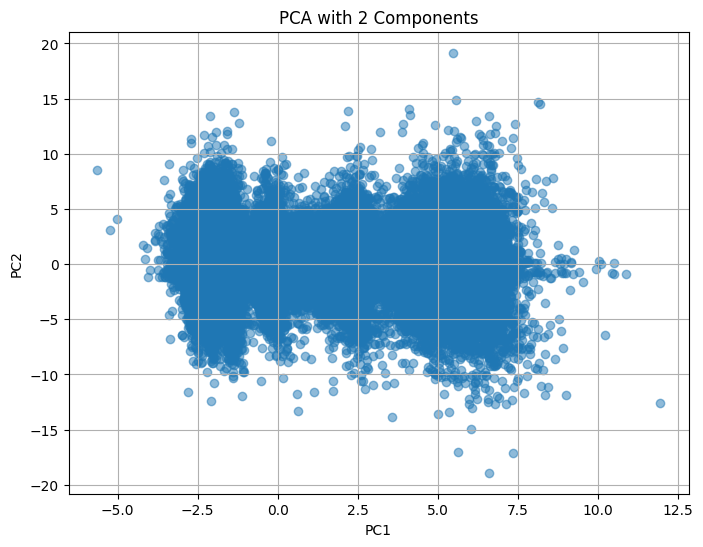

In [ ]:
# EDA functions
def summarize_dataset(df):
    print(" Shape:", df.shape)
    print("\n Data types:\n", df.dtypes)
    print("\n Missing values per column:\n", df.isnull().sum())
    print("\n Descriptive statistics:\n", df.describe().T)

def visualize_distributions(df):
    numeric_cols = df.select_dtypes(include=np.number).columns
    df[numeric_cols].hist(bins=50, figsize=(14, 10))
    plt.suptitle("Histograms of Numeric Features")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 6))
    sns.boxplot(data=df[numeric_cols])
    plt.title("Boxplot of Numeric Features")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

def correlation_matrix(df):
    corr = df.select_dtypes(include=np.number).corr()
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.show()

def feature_engineering_ideas():
    print("\n Feature Engineering Suggestions:")
    print("- Consider rolling mean or volatility indicators.")
    print("- Add RSI, MACD, moving averages, or candlestick patterns.")
    print("- Extract temporal features like market open windows.")
    print("- Normalize or scale volume / trade_count if skewed.")

def apply_pca(df, n_components=2):
    numeric_df = df.select_dtypes(include=np.number).dropna()
    X_scaled = StandardScaler().fit_transform(numeric_df)

    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)
    plt.title(f"PCA with {n_components} Components")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()

def run_eda(df, label):
    print(f"\n Running EDA for {label}")
    summarize_dataset(df)
    visualize_distributions(df)
    correlation_matrix(df)
    feature_engineering_ideas()
    apply_pca(df)

# Execute EDA
run_eda(df_NVDA_1min_filtered_odd, "NVDA 1-Min Odd")
run_eda(df_NVDA_2min_filtered, "NVDA 2-Min All")

In [ ]:
# Moving averages on closing price
df_NVDA_1min_filtered_odd['ma_5'] = df_NVDA_1min_filtered_odd['close'].rolling(window=5).mean()
df_NVDA_1min_filtered_odd['ma_10'] = df_NVDA_1min_filtered_odd['close'].rolling(window=10).mean()
df_NVDA_1min_filtered_odd['ma_20'] = df_NVDA_1min_filtered_odd['close'].rolling(window=20).mean()


/tmp/ipython-input-175-181387384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_1min_filtered_odd['ma_5'] = df_NVDA_1min_filtered_odd['close'].rolling(window=5).mean()
/tmp/ipython-input-175-181387384.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_1min_filtered_odd['ma_10'] = df_NVDA_1min_filtered_odd['close'].rolling(window=10).mean()
/tmp/ipython-input-175-181387384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [ ]:
# Buy vs Sell volume (approximation)
df_NVDA_1min_filtered_odd['buy_volume'] = np.where(df_NVDA_1min_filtered_odd['close'] > df_NVDA_1min_filtered_odd['open'],
                                                   df_NVDA_1min_filtered_odd['volume'], 0)
df_NVDA_1min_filtered_odd['sell_volume'] = np.where(df_NVDA_1min_filtered_odd['close'] <= df_NVDA_1min_filtered_odd['open'],
                                                    df_NVDA_1min_filtered_odd['volume'], 0)

/tmp/ipython-input-176-2184407259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_1min_filtered_odd['buy_volume'] = np.where(df_NVDA_1min_filtered_odd['close'] > df_NVDA_1min_filtered_odd['open'],
/tmp/ipython-input-176-2184407259.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_1min_filtered_odd['sell_volume'] = np.where(df_NVDA_1min_filtered_odd['close'] <= df_NVDA_1min_filtered_odd['open'],


In [ ]:
# Daily returns
df_NVDA_1min_filtered_odd['date'] = pd.to_datetime(df_NVDA_1min_filtered_odd['timestamp']).dt.date
daily_close = df_NVDA_1min_filtered_odd.groupby('date')['close'].agg(['first', 'last'])
daily_close['daily_return'] = daily_close['last'].pct_change()

/tmp/ipython-input-177-3998494445.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_1min_filtered_odd['date'] = pd.to_datetime(df_NVDA_1min_filtered_odd['timestamp']).dt.date


In [ ]:
# preview results
print(df_NVDA_1min_filtered_odd[['timestamp', 'open', 'close', 'buy_volume', 'sell_volume', 'ma_5', 'ma_10', 'ma_20']].head())
print("\n Sample of daily returns:")
print(daily_close.head())

                   timestamp       open     close  buy_volume  sell_volume  \
81 2021-01-04 09:31:00-05:00  12.964462  13.01025   1518640.0          0.0   
83 2021-01-04 09:33:00-05:00  12.982747  12.99775   1516240.0          0.0   
85 2021-01-04 09:35:00-05:00  13.006250  13.03200   1213480.0          0.0   
87 2021-01-04 09:37:00-05:00  13.008000  13.00450         0.0    1367320.0   
89 2021-01-04 09:39:00-05:00  13.042375  13.03400         0.0    1297240.0   

       ma_5  ma_10  ma_20  
81      NaN    NaN    NaN  
83      NaN    NaN    NaN  
85      NaN    NaN    NaN  
87      NaN    NaN    NaN  
89  13.0157    NaN    NaN  

 Sample of daily returns:
                first       last  daily_return
date                                          
2021-01-04  13.010250  13.100002           NaN
2021-01-05  13.159252  13.413750      0.023950
2021-01-06  13.126000  12.709500     -0.052502
2021-01-07  12.981250  13.325000      0.048428
2021-01-08  13.399480  13.285750     -0.002946


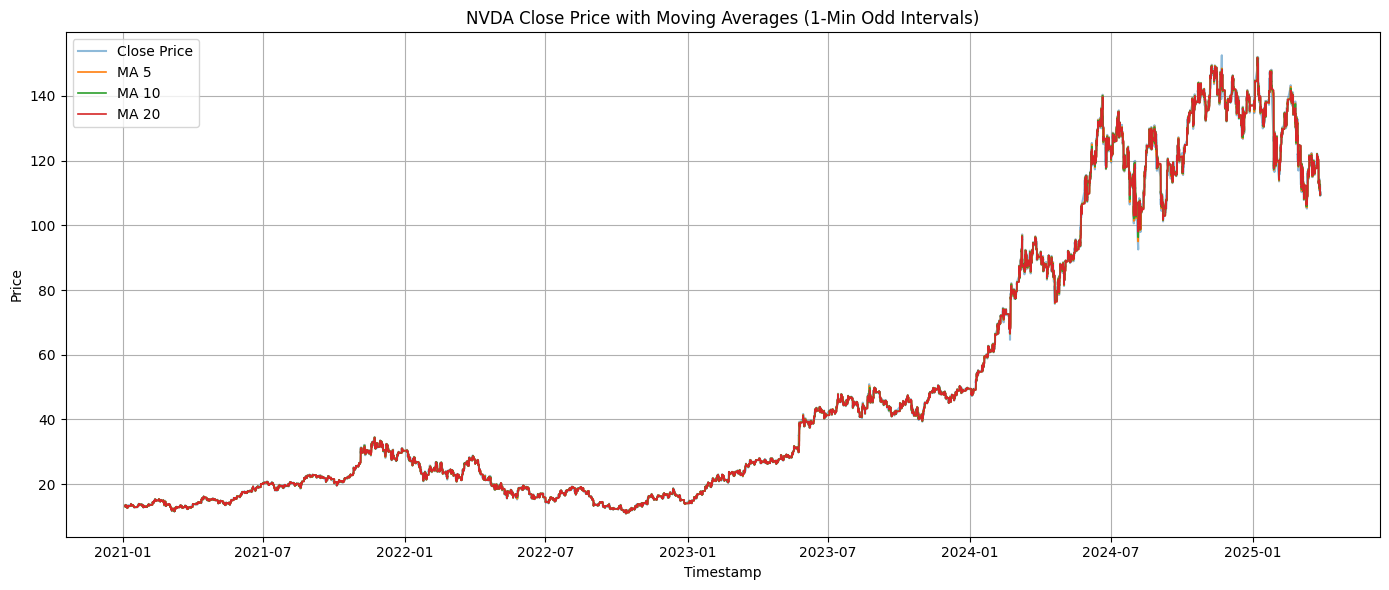

In [ ]:
# Plot Moving Averages
plt.figure(figsize=(14, 6))
plt.plot(df_NVDA_1min_filtered_odd['timestamp'], df_NVDA_1min_filtered_odd['close'], label='Close Price', alpha=0.5)
plt.plot(df_NVDA_1min_filtered_odd['timestamp'], df_NVDA_1min_filtered_odd['ma_5'], label='MA 5', linewidth=1.2)
plt.plot(df_NVDA_1min_filtered_odd['timestamp'], df_NVDA_1min_filtered_odd['ma_10'], label='MA 10', linewidth=1.2)
plt.plot(df_NVDA_1min_filtered_odd['timestamp'], df_NVDA_1min_filtered_odd['ma_20'], label='MA 20', linewidth=1.2)
plt.title("NVDA Close Price with Moving Averages (1-Min Odd Intervals)")
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
def add_all_moving_averages(df, periods=[10, 21, 50, 200]):
    result = df.copy()
    for p in periods:
        result[f'sma_{p}'] = result['close'].rolling(window=p).mean()
        result[f'ema_{p}'] = result['close'].ewm(span=p, adjust=False).mean()
        weights = np.arange(1, p + 1)
        result[f'lwma_{p}'] = result['close'].rolling(p).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)
        ema = result['close'].ewm(span=p, adjust=False).mean()
        result[f'smma_{p}'] = ema.ewm(span=p, adjust=False).mean()
    return result

In [ ]:
# Daily resampling for 1-min filtered odd data
df_1min_daily = df_NVDA_1min_filtered_odd.copy()
df_1min_daily['timestamp'] = pd.to_datetime(df_1min_daily['timestamp'])
df_1min_daily.set_index('timestamp', inplace=True)
df_1min_daily = df_1min_daily.resample('1D').agg({
    'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'
}).dropna()
df_1min_daily = add_all_moving_averages(df_1min_daily)

# Daily resampling for 2-min filtered data
df_2min_daily = df_NVDA_2min_filtered.copy()
df_2min_daily['timestamp'] = pd.to_datetime(df_2min_daily['timestamp'])
df_2min_daily.set_index('timestamp', inplace=True)
df_2min_daily = df_2min_daily.resample('1D').agg({
    'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'
}).dropna()
df_2min_daily = add_all_moving_averages(df_2min_daily)

/tmp/ipython-input-20-916683719.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_1min_filtered_odd['timestamp'] = pd.to_datetime(df_NVDA_1min_filtered_odd['timestamp'])


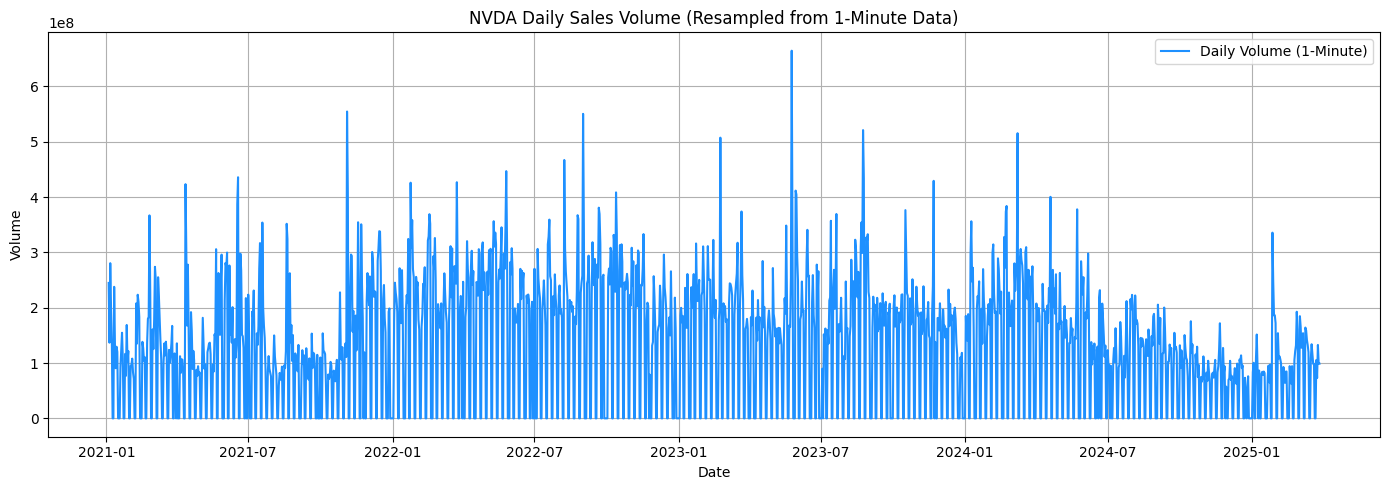

In [ ]:
# Ensure 'timestamp' is datetime and set as index
df_NVDA_1min_filtered_odd['timestamp'] = pd.to_datetime(df_NVDA_1min_filtered_odd['timestamp'])
df_NVDA_1min_filtered_odd.set_index('timestamp', inplace=True)
df_NVDA_1min_filtered_odd.sort_index(inplace=True)  # Optional: ensure sorted by time

# Now resample and plot
daily_volume_1min = df_NVDA_1min_filtered_odd['volume'].resample('1D').sum()

plt.figure(figsize=(14, 5))
plt.plot(daily_volume_1min.index, daily_volume_1min.values, color='dodgerblue', label='Daily Volume (1-Minute)')
plt.title("NVDA Daily Sales Volume (Resampled from 1-Minute Data)")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipython-input-21-1590356216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_2min_filtered['timestamp'] = pd.to_datetime(df_NVDA_2min_filtered['timestamp'])  # Ensure datetime


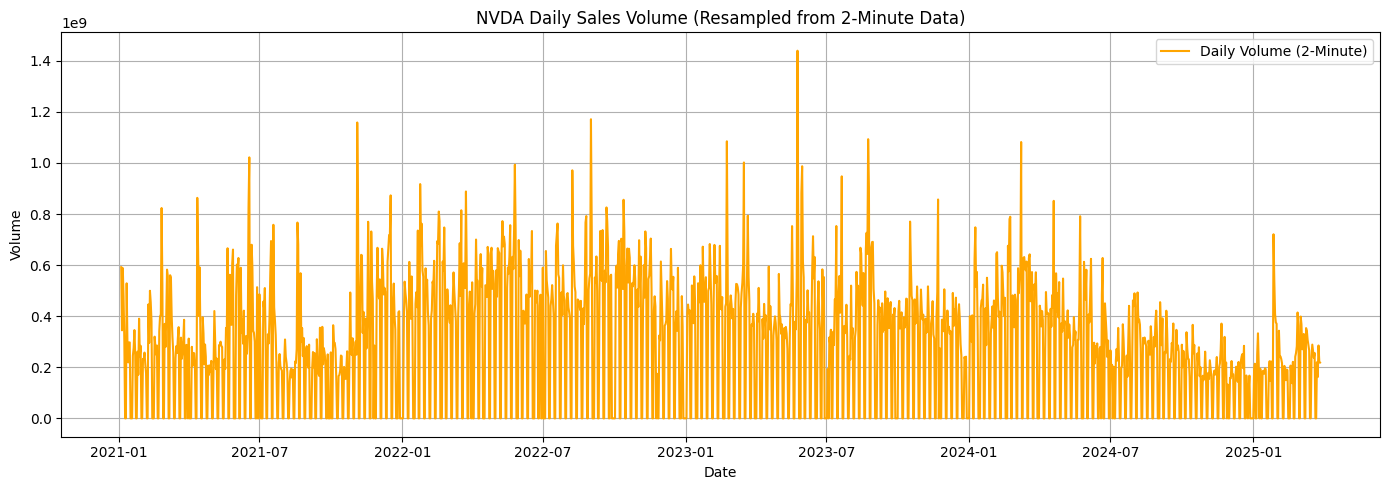

In [ ]:
# Resample and plot daily volume (2-Minute)
df_NVDA_2min_filtered['timestamp'] = pd.to_datetime(df_NVDA_2min_filtered['timestamp'])  # Ensure datetime
df_NVDA_2min_filtered.set_index('timestamp', inplace=True)
df_NVDA_2min_filtered.sort_index(inplace=True)

daily_volume_2min = df_NVDA_2min_filtered['volume'].resample('1D').sum()

plt.figure(figsize=(14, 5))
plt.plot(daily_volume_2min.index, daily_volume_2min.values, color='orange', label='Daily Volume (2-Minute)')
plt.title("NVDA Daily Sales Volume (Resampled from 2-Minute Data)")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#Feature Engineering - Volume

Strong uptrend: rising price + rising volume

Strong downtrend: falling price + rising volume

Weak uptrend/downtrend: price moving with low volume

Potential reversal: high price + low volume + low trade count


In [ ]:
df_NVDA_1min_filtered_odd.sort_index(inplace=True)


In [ ]:
# Calculate percentage changes
df_NVDA_2min_filtered['price_change'] = df_NVDA_2min_filtered['close'].pct_change()
df_NVDA_2min_filtered['volume_change'] = df_NVDA_2min_filtered['volume'].pct_change()

# Calculate rolling thresholds (excluding current row using shift)
vol_thresh = df_NVDA_2min_filtered['volume'].shift(1).rolling(window=30).mean() * 0.4
count_thresh = df_NVDA_2min_filtered['trade_count'].shift(1).rolling(window=30).mean()

# Strong Uptrend: rising price + higher-than-average volume
df_NVDA_2min_filtered['strong_uptrend'] = (
    (df_NVDA_2min_filtered['price_change'] > 0) &
    (df_NVDA_2min_filtered['volume'] / (df_NVDA_2min_filtered['trade_count'] + 1) >= 200)
).astype(int)

# Strong Downtrend: falling price + higher-than-average volume
df_NVDA_2min_filtered['strong_downtrend'] = (
    (df_NVDA_2min_filtered['price_change'] < 0) &
    (df_NVDA_2min_filtered['volume'] / (df_NVDA_2min_filtered['trade_count'] + 1) >= 200)
).astype(int)

# Weak Momentum: low volume and low trade count (tightened to 80% threshold)
df_NVDA_2min_filtered['weak_momentum'] = (
    (df_NVDA_2min_filtered['volume'] < 0.8 * vol_thresh) &
    (df_NVDA_2min_filtered['trade_count'] < 0.8 * count_thresh)
).astype(int)

# Rolling max for reversal detection
rolling_max = df_NVDA_2min_filtered['close'].shift(1).rolling(window=50).max()

# Potential Reversal: near high + low volume + low trade count (tightened to 75%)
df_NVDA_2min_filtered['potential_reversal'] = (
    (df_NVDA_2min_filtered['close'] > 0.995 * rolling_max) &
    (df_NVDA_2min_filtered['volume'] < 0.75 * vol_thresh) &
    (df_NVDA_2min_filtered['trade_count'] < 0.75 * count_thresh)
).astype(int)

# Optional: Preview last few rows
df_NVDA_2min_filtered[['close', 'volume', 'trade_count', 'strong_uptrend', 'strong_downtrend', 'weak_momentum', 'potential_reversal']].tail(10)

/tmp/ipython-input-23-3951311807.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_2min_filtered['price_change'] = df_NVDA_2min_filtered['close'].pct_change()
/tmp/ipython-input-23-3951311807.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_2min_filtered['volume_change'] = df_NVDA_2min_filtered['volume'].pct_change()
/tmp/ipython-input-23-3951311807.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

close    volume  trade_count  strong_uptrend  \
timestamp                                                                    
2025-03-28 16:12:00-04:00  109.3988   37826.0        392.0               0   
2025-03-28 16:14:00-04:00  109.3800  102186.0        351.0               0   
2025-03-28 16:16:00-04:00  109.3900   35098.0        444.0               0   
2025-03-28 16:18:00-04:00  109.3998   35531.0        583.0               0   
2025-03-28 16:20:00-04:00  109.4400   18932.0        301.0               0   
2025-03-28 16:22:00-04:00  109.4000   21800.0        298.0               0   
2025-03-28 16:24:00-04:00  109.4200    8358.0        245.0               0   
2025-03-28 16:26:00-04:00  109.3600   35888.0        482.0               0   
2025-03-28 16:28:00-04:00  109.3500   40916.0        507.0               0   
2025-03-28 16:30:00-04:00  109.3207   20983.0        275.0               0   

                           strong_downtrend  weak_momentum  potential_reversal  
timestamp                                                                       
2025-03-28 16:12:00-04:00                 0              1                   0  
2025-03-28 16:14:00-04:00                 1              1                   0  
2025-03-28 16:16:00-04:00                 0              1                   0  
2025-03-28 16:18:00-04:00                 0              1                   0  
2025-03-28 16:20:00-04:00                 0              1                   0  
2025-03-28 16:22:00-04:00                 0              1                   0  
2025-03-28 16:24:00-04:00                 0              1                   0  
2025-03-28 16:26:00-04:00                 0              1                   0  
2025-03-28 16:28:00-04:00                 0              1                   0  
2025-03-28 16:30:00-04:00                 0              1                   0

In [ ]:
df_NVDA_2min_filtered.index = pd.to_datetime(df_NVDA_2min_filtered.index)
df_NVDA_2min_filtered.sort_index(inplace=True)


In [ ]:
# Calculate price and volume changes
df_NVDA_1min_filtered_odd['price_change'] = df_NVDA_1min_filtered_odd['close'].pct_change()
df_NVDA_1min_filtered_odd['volume_change'] = df_NVDA_1min_filtered_odd['volume'].pct_change()

# Rolling thresholds (exclude current row using shift)
vol_thresh_1min = df_NVDA_1min_filtered_odd['volume'].shift(1).rolling(window=30).mean() * 0.5
count_thresh_1min = df_NVDA_1min_filtered_odd['trade_count'].shift(1).rolling(window=30).mean()

# Strong Uptrend: rising price + high volume
df_NVDA_1min_filtered_odd['strong_uptrend'] = (
    (df_NVDA_1min_filtered_odd['price_change'] > 0) &
    (df_NVDA_1min_filtered_odd['volume'] / (df_NVDA_1min_filtered_odd['trade_count'] + 1) >= 200)
).astype(int)

# Strong Downtrend: falling price + high volume
institutional_trade_thresh_1min = 150

df_NVDA_1min_filtered_odd['strong_downtrend'] = (
    (df_NVDA_1min_filtered_odd['price_change'] < 0) &
    (df_NVDA_1min_filtered_odd['trade_count'] < institutional_trade_thresh_1min)
).astype(int)

# Weak Momentum: low volume + low trade count (tightened threshold)
df_NVDA_1min_filtered_odd['weak_momentum'] = (
    (df_NVDA_1min_filtered_odd['volume'] < 0.8 * vol_thresh_1min) &
    (df_NVDA_1min_filtered_odd['trade_count'] < 0.8 * count_thresh_1min)
).astype(int)

# Potential Reversal: price near high + low volume + low trade activity
rolling_max_1min = df_NVDA_1min_filtered_odd['close'].shift(1).rolling(window=50).max()
df_NVDA_1min_filtered_odd['potential_reversal'] = (
    (df_NVDA_1min_filtered_odd['close'] > 0.995 * rolling_max_1min) &
    (df_NVDA_1min_filtered_odd['volume'] < 0.75 * vol_thresh_1min) &
    (df_NVDA_1min_filtered_odd['trade_count'] < 0.75 * count_thresh_1min)
).astype(int)

# Optional: Preview engineered signals
df_NVDA_1min_filtered_odd[['close', 'volume', 'trade_count', 'strong_uptrend', 'strong_downtrend', 'weak_momentum', 'potential_reversal']].tail(10)

/tmp/ipython-input-25-2295618953.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_1min_filtered_odd['price_change'] = df_NVDA_1min_filtered_odd['close'].pct_change()
/tmp/ipython-input-25-2295618953.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_1min_filtered_odd['volume_change'] = df_NVDA_1min_filtered_odd['volume'].pct_change()
/tmp/ipython-input-25-2295618953.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

close   volume  trade_count  strong_uptrend  \
timestamp                                                                   
2025-03-28 16:11:00-04:00  109.3400  35223.0        352.0               0   
2025-03-28 16:13:00-04:00  109.3988  21408.0        195.0               0   
2025-03-28 16:15:00-04:00  109.3800  83544.0        168.0               0   
2025-03-28 16:17:00-04:00  109.3900  23218.0        271.0               0   
2025-03-28 16:19:00-04:00  109.3998   9973.0        173.0               0   
2025-03-28 16:21:00-04:00  109.4400   9027.0        123.0               0   
2025-03-28 16:23:00-04:00  109.4000  10459.0        148.0               0   
2025-03-28 16:25:00-04:00  109.4200   5289.0        134.0               0   
2025-03-28 16:27:00-04:00  109.3600  25097.0        285.0               0   
2025-03-28 16:29:00-04:00  109.3500  19335.0        221.0               0   

                           strong_downtrend  weak_momentum  potential_reversal  
timestamp                                                                       
2025-03-28 16:11:00-04:00                 0              1                   0  
2025-03-28 16:13:00-04:00                 0              1                   0  
2025-03-28 16:15:00-04:00                 0              1                   0  
2025-03-28 16:17:00-04:00                 0              1                   0  
2025-03-28 16:19:00-04:00                 0              1                   0  
2025-03-28 16:21:00-04:00                 0              1                   0  
2025-03-28 16:23:00-04:00                 1              1                   0  
2025-03-28 16:25:00-04:00                 0              1                   0  
2025-03-28 16:27:00-04:00                 0              1                   0  
2025-03-28 16:29:00-04:00                 0              1                   0

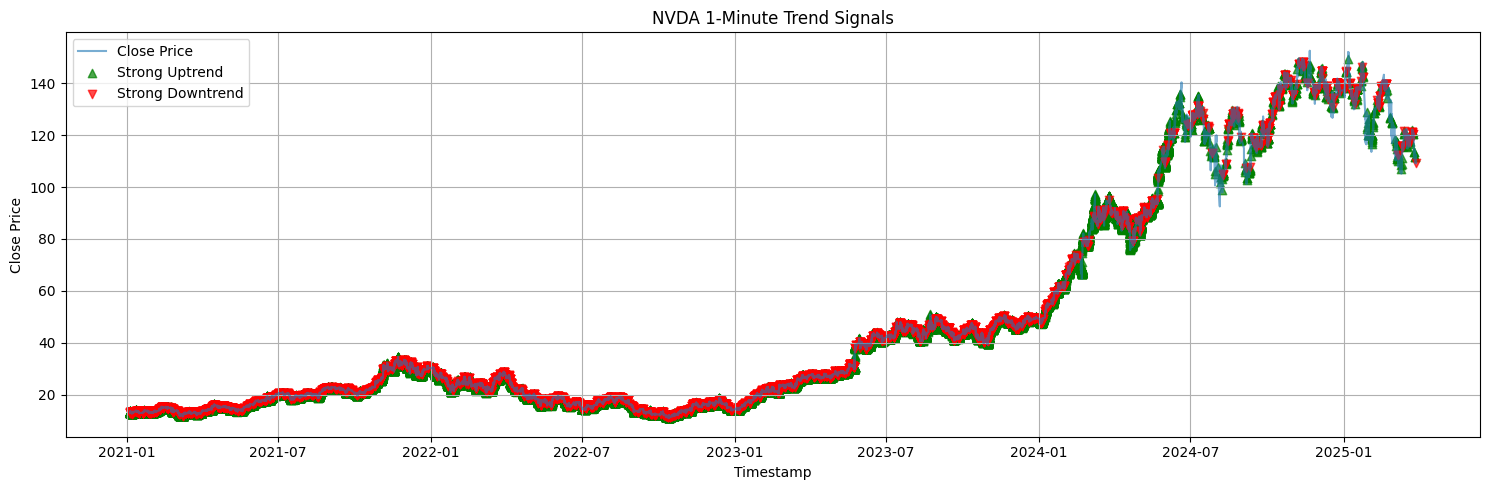

In [ ]:
# ----- 1-MINUTE VISUALIZATION -----
plt.figure(figsize=(15, 5))
plt.plot(df_NVDA_1min_filtered_odd['close'], label='Close Price', alpha=0.6)

plt.scatter(
    df_NVDA_1min_filtered_odd[df_NVDA_1min_filtered_odd['strong_uptrend'] == 1].index,
    df_NVDA_1min_filtered_odd[df_NVDA_1min_filtered_odd['strong_uptrend'] == 1]['close'],
    color='green', label='Strong Uptrend', marker='^', alpha=0.7
)

plt.scatter(
    df_NVDA_1min_filtered_odd[df_NVDA_1min_filtered_odd['strong_downtrend'] == 1].index,
    df_NVDA_1min_filtered_odd[df_NVDA_1min_filtered_odd['strong_downtrend'] == 1]['close'],
    color='red', label='Strong Downtrend', marker='v', alpha=0.7
)

plt.title("NVDA 1-Minute Trend Signals")
plt.xlabel("Timestamp")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

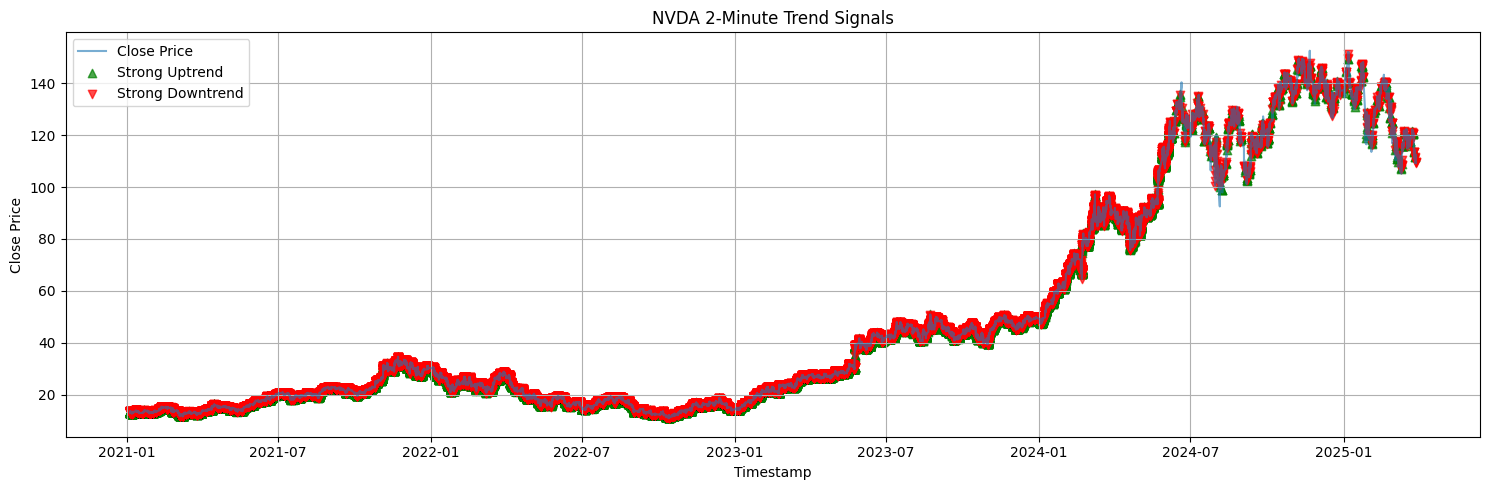

In [ ]:
# ---- 2-MINUTE SIGNAL VISUALIZATION ----
plt.figure(figsize=(15, 5))
plt.plot(df_NVDA_2min_filtered['close'], label='Close Price', alpha=0.6)

plt.scatter(
    df_NVDA_2min_filtered[df_NVDA_2min_filtered['strong_uptrend'] == 1].index,
    df_NVDA_2min_filtered[df_NVDA_2min_filtered['strong_uptrend'] == 1]['close'],
    color='green', label='Strong Uptrend', marker='^', alpha=0.7
)

plt.scatter(
    df_NVDA_2min_filtered[df_NVDA_2min_filtered['strong_downtrend'] == 1].index,
    df_NVDA_2min_filtered[df_NVDA_2min_filtered['strong_downtrend'] == 1]['close'],
    color='red', label='Strong Downtrend', marker='v', alpha=0.7
)

plt.title("NVDA 2-Minute Trend Signals")
plt.xlabel("Timestamp")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Feature engineering 2

  - vwap_spread: Difference between closing price and VWAP

  - price_to_vwap_ratio: Normalized price position relative to VWAP

  - vwap_above_flag: Binary flag indicating if the price is above VWAP

  - volume_zscore: Z-score of volume to detect abnormal trading activity

  - trade_per_volume: Trade density indicator (number of trades per unit of volume)

In [ ]:
# For 1-minute dataframe
# 1. Spread between close price and VWAP
df_NVDA_1min_filtered_odd['vwap_spread'] = df_NVDA_1min_filtered_odd['close'] - df_NVDA_1min_filtered_odd['vwap']

# 2. Normalized price position relative to VWAP
df_NVDA_1min_filtered_odd['price_to_vwap_ratio'] = df_NVDA_1min_filtered_odd['close'] / df_NVDA_1min_filtered_odd['vwap']

# 3. Binary flag if price is trading above VWAP (bullish bias)
df_NVDA_1min_filtered_odd['vwap_above_flag'] = (df_NVDA_1min_filtered_odd['close'] > df_NVDA_1min_filtered_odd['vwap']).astype(int)

# ---- Volume Z-Score ----

# Calculate rolling mean and std
df_NVDA_1min_filtered_odd['rolling_volume_mean'] = df_NVDA_1min_filtered_odd['volume'].rolling(window=30).mean()
df_NVDA_1min_filtered_odd['rolling_volume_std'] = df_NVDA_1min_filtered_odd['volume'].rolling(window=30).std()

# 4. Z-score to detect abnormal volume spikes (±2 std is often considered extreme)
df_NVDA_1min_filtered_odd['volume_zscore'] = (
    (df_NVDA_1min_filtered_odd['volume'] - df_NVDA_1min_filtered_odd['rolling_volume_mean']) /
    (df_NVDA_1min_filtered_odd['rolling_volume_std'] + 1e-6)
)


# ---- Trade Density Feature ----

# 5. Trade per volume: large value → more retail, small value → institutional
df_NVDA_1min_filtered_odd['trade_per_volume'] = df_NVDA_1min_filtered_odd['trade_count'] / (df_NVDA_1min_filtered_odd['volume'] + 1)

# 6. Institutional flow signal: low trade density + high volume
vol_thresh = df_NVDA_1min_filtered_odd['rolling_volume_mean']
density_thresh = df_NVDA_1min_filtered_odd['trade_per_volume'].rolling(window=30).mean()

df_NVDA_1min_filtered_odd['institutional_flow_flag'] = (
    (df_NVDA_1min_filtered_odd['volume'] > 1.2 * vol_thresh) &
    (df_NVDA_1min_filtered_odd['trade_per_volume'] < 0.8 * density_thresh)
).astype(int)

# --- Clean up temporary cols if needed
df_NVDA_1min_filtered_odd.drop(['rolling_volume_mean', 'rolling_volume_std'], axis=1, inplace=True)

/tmp/ipython-input-28-2666214699.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_1min_filtered_odd['vwap_spread'] = df_NVDA_1min_filtered_odd['close'] - df_NVDA_1min_filtered_odd['vwap']
/tmp/ipython-input-28-2666214699.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_1min_filtered_odd['price_to_vwap_ratio'] = df_NVDA_1min_filtered_odd['close'] / df_NVDA_1min_filtered_odd['vwap']
/tmp/ipython-input-28-2666214699.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

/tmp/ipython-input-29-3452550833.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_1min_filtered_odd['vwap_spread'] = df_NVDA_1min_filtered_odd['close'] - df_NVDA_1min_filtered_odd['vwap']
/tmp/ipython-input-29-3452550833.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_1min_filtered_odd['price_to_vwap_ratio'] = df_NVDA_1min_filtered_odd['close'] / df_NVDA_1min_filtered_odd['vwap']
/tmp/ipython-input-29-3452550833.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

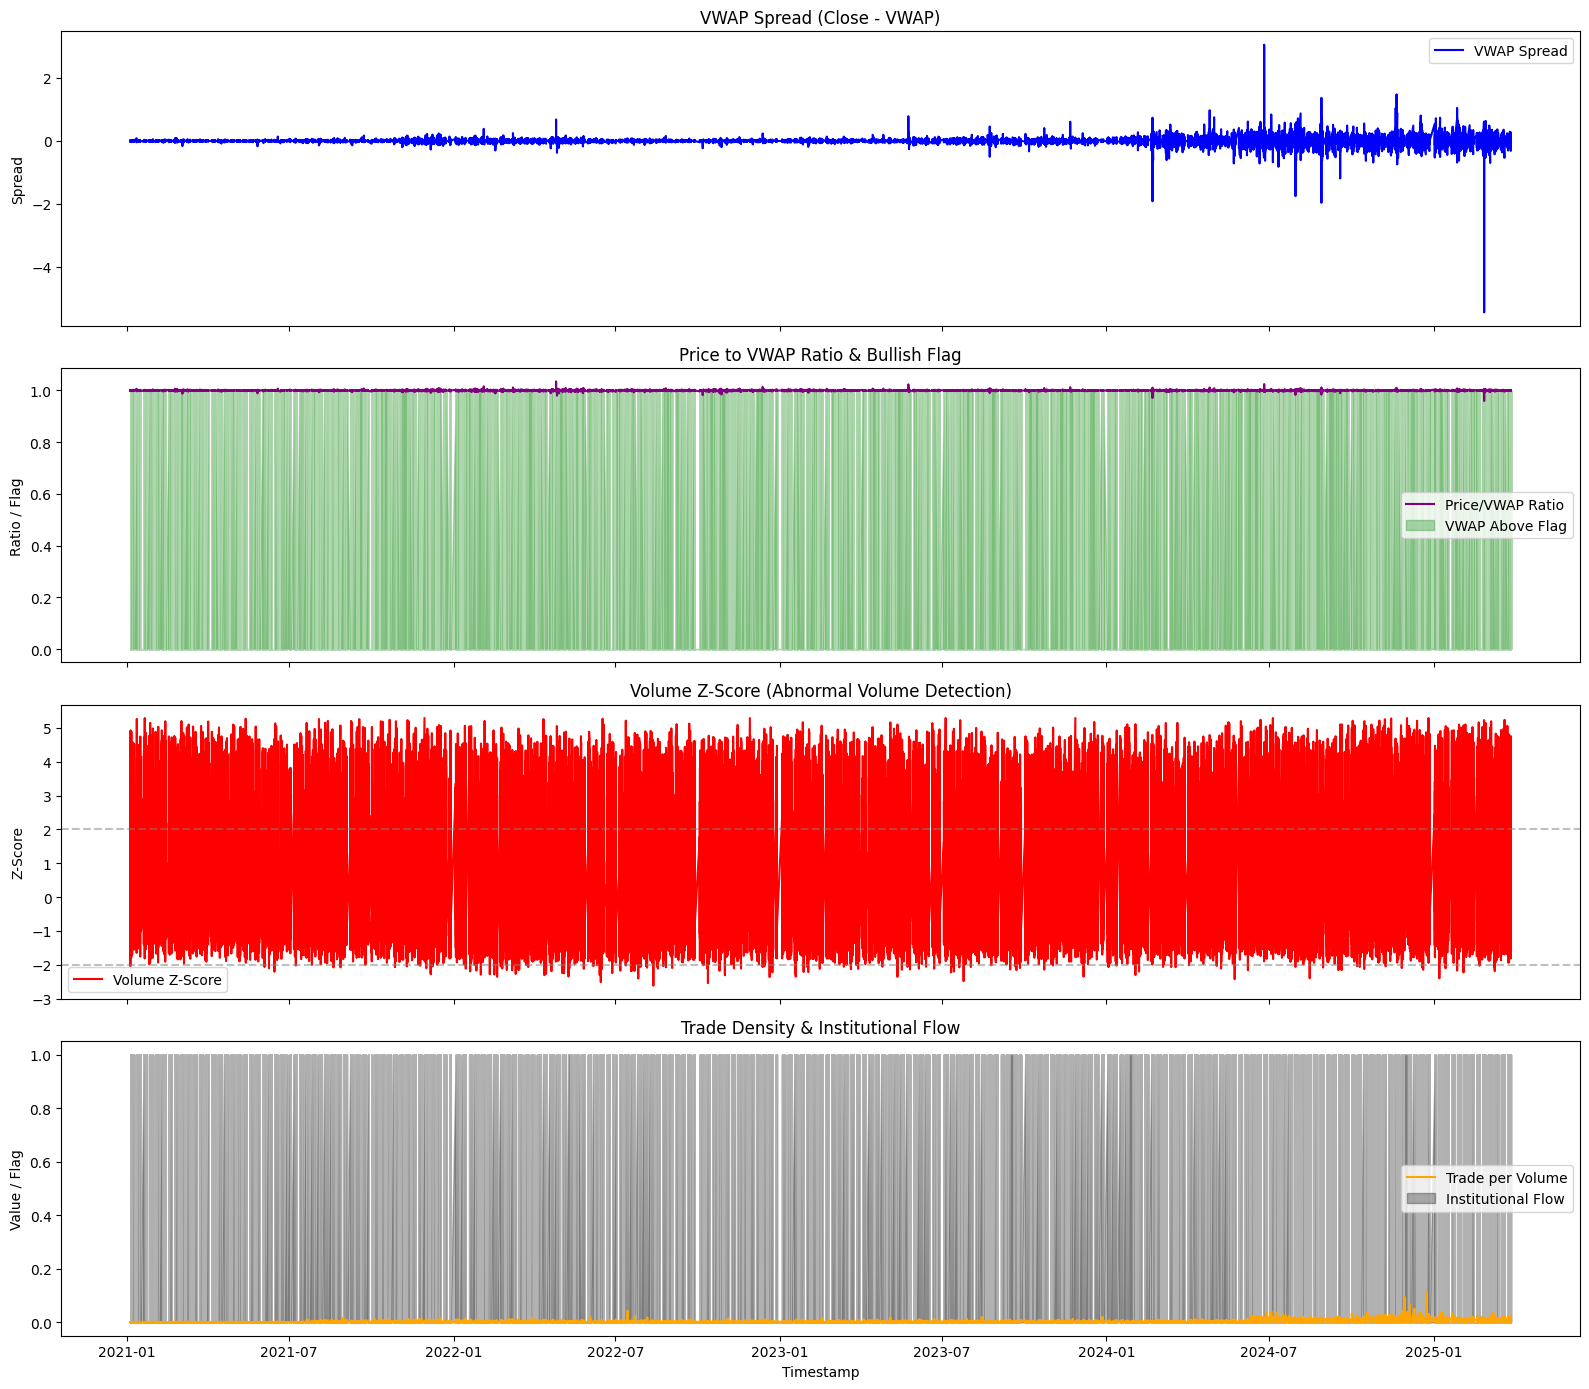

In [ ]:
# --- Feature Engineering ---
df_NVDA_1min_filtered_odd['vwap_spread'] = df_NVDA_1min_filtered_odd['close'] - df_NVDA_1min_filtered_odd['vwap']
df_NVDA_1min_filtered_odd['price_to_vwap_ratio'] = df_NVDA_1min_filtered_odd['close'] / df_NVDA_1min_filtered_odd['vwap']
df_NVDA_1min_filtered_odd['vwap_above_flag'] = (df_NVDA_1min_filtered_odd['close'] > df_NVDA_1min_filtered_odd['vwap']).astype(int)

# Rolling stats for volume z-score
df_NVDA_1min_filtered_odd['rolling_volume_mean'] = df_NVDA_1min_filtered_odd['volume'].rolling(window=30).mean()
df_NVDA_1min_filtered_odd['rolling_volume_std'] = df_NVDA_1min_filtered_odd['volume'].rolling(window=30).std()
df_NVDA_1min_filtered_odd['volume_zscore'] = (
    (df_NVDA_1min_filtered_odd['volume'] - df_NVDA_1min_filtered_odd['rolling_volume_mean']) /
    (df_NVDA_1min_filtered_odd['rolling_volume_std'] + 1e-6)
)

# Trade density features
df_NVDA_1min_filtered_odd['trade_per_volume'] = df_NVDA_1min_filtered_odd['trade_count'] / (df_NVDA_1min_filtered_odd['volume'] + 1)
vol_thresh = df_NVDA_1min_filtered_odd['rolling_volume_mean']
density_thresh = df_NVDA_1min_filtered_odd['trade_per_volume'].rolling(window=30).mean()
df_NVDA_1min_filtered_odd['institutional_flow_flag'] = (
    (df_NVDA_1min_filtered_odd['volume'] > 1.2 * vol_thresh) &
    (df_NVDA_1min_filtered_odd['trade_per_volume'] < 0.8 * density_thresh)
).astype(int)

# Drop temp columns
df_NVDA_1min_filtered_odd.drop(['rolling_volume_mean', 'rolling_volume_std'], axis=1, inplace=True)

# --- Plotting ---
# Reset index just in case
df = df_NVDA_1min_filtered_odd.copy()
if df.index.name == 'timestamp':
    df.reset_index(inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'])

fig, axs = plt.subplots(4, 1, figsize=(16, 14), sharex=True)

# 1. VWAP Spread
axs[0].plot(df['timestamp'], df['vwap_spread'], label='VWAP Spread', color='blue')
axs[0].set_title('VWAP Spread (Close - VWAP)')
axs[0].set_ylabel('Spread')
axs[0].legend()

# 2. Price/VWAP Ratio + Flag
axs[1].plot(df['timestamp'], df['price_to_vwap_ratio'], label='Price/VWAP Ratio', color='purple')
axs[1].fill_between(df['timestamp'], 0, df['vwap_above_flag'], color='green', alpha=0.3, label='VWAP Above Flag')
axs[1].set_title('Price to VWAP Ratio & Bullish Flag')
axs[1].set_ylabel('Ratio / Flag')
axs[1].legend()

# 3. Volume Z-Score
axs[2].plot(df['timestamp'], df['volume_zscore'], label='Volume Z-Score', color='red')
axs[2].axhline(2, linestyle='--', color='gray', alpha=0.5)
axs[2].axhline(-2, linestyle='--', color='gray', alpha=0.5)
axs[2].set_title('Volume Z-Score (Abnormal Volume Detection)')
axs[2].set_ylabel('Z-Score')
axs[2].legend()

# 4. Trade Density & Institutional Flow
axs[3].plot(df['timestamp'], df['trade_per_volume'], label='Trade per Volume', color='orange')
axs[3].fill_between(df['timestamp'], 0, df['institutional_flow_flag'], color='black', alpha=0.3, label='Institutional Flow')
axs[3].set_title('Trade Density & Institutional Flow')
axs[3].set_ylabel('Value / Flag')
axs[3].legend()

plt.xlabel('Timestamp')
plt.tight_layout()
plt.show()


In [ ]:
# for 2 minute dataframe
# VWAP-related features
df_NVDA_2min_filtered['vwap_spread'] = df_NVDA_2min_filtered['close'] - df_NVDA_2min_filtered['vwap']
df_NVDA_2min_filtered['price_to_vwap_ratio'] = df_NVDA_2min_filtered['close'] / df_NVDA_2min_filtered['vwap']
df_NVDA_2min_filtered['vwap_above_flag'] = (df_NVDA_2min_filtered['close'] > df_NVDA_2min_filtered['vwap']).astype(int)

# Rolling volume stats
df_NVDA_2min_filtered['rolling_volume_mean'] = df_NVDA_2min_filtered['volume'].rolling(window=30).mean()
df_NVDA_2min_filtered['rolling_volume_std'] = df_NVDA_2min_filtered['volume'].rolling(window=30).std()

# Volume z-score
df_NVDA_2min_filtered['volume_zscore_2'] = (
    (df_NVDA_2min_filtered['volume'] - df_NVDA_2min_filtered['rolling_volume_mean']) /
    (df_NVDA_2min_filtered['rolling_volume_std'] + 1e-6)
)

# Trade density
df_NVDA_2min_filtered['trade_per_volume'] = df_NVDA_2min_filtered['trade_count'] / (df_NVDA_2min_filtered['volume'] + 1)
density_thresh_2min = df_NVDA_2min_filtered['trade_per_volume'].rolling(window=30).mean()

# Institutional flag
df_NVDA_2min_filtered['institutional_flow_flag_2'] = (
    (df_NVDA_2min_filtered['volume'] > 1.2 * df_NVDA_2min_filtered['rolling_volume_mean']) &
    (df_NVDA_2min_filtered['trade_per_volume'] < 0.8 * density_thresh_2min)
).astype(int)

# Cleanup
df_NVDA_2min_filtered.drop(['rolling_volume_mean', 'rolling_volume_std'], axis=1, inplace=True)


/tmp/ipython-input-30-3416768995.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_2min_filtered['vwap_spread'] = df_NVDA_2min_filtered['close'] - df_NVDA_2min_filtered['vwap']
/tmp/ipython-input-30-3416768995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_2min_filtered['price_to_vwap_ratio'] = df_NVDA_2min_filtered['close'] / df_NVDA_2min_filtered['vwap']
/tmp/ipython-input-30-3416768995.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [ ]:
# ---- Feature Engineering 1 for 1-minute ----
df_NVDA_1min_filtered_odd['price_change'] = df_NVDA_1min_filtered_odd['close'].pct_change()
df_NVDA_1min_filtered_odd['volume_change'] = df_NVDA_1min_filtered_odd['volume'].pct_change()

vol_thresh_1min = df_NVDA_1min_filtered_odd['volume'].rolling(window=30).mean() * 0.5
count_thresh_1min = df_NVDA_1min_filtered_odd['trade_count'].rolling(window=30).mean()

df_NVDA_1min_filtered_odd['strong_uptrend'] = (
    (df_NVDA_1min_filtered_odd['price_change'] > 0) &
    (df_NVDA_1min_filtered_odd['volume'] > vol_thresh_1min)
).astype(int)

df_NVDA_1min_filtered_odd['strong_downtrend'] = (
    (df_NVDA_1min_filtered_odd['price_change'] < 0) &
    (df_NVDA_1min_filtered_odd['volume'] > vol_thresh_1min)
).astype(int)

df_NVDA_1min_filtered_odd['weak_momentum'] = (
    (df_NVDA_1min_filtered_odd['volume'] < vol_thresh_1min) &
    (df_NVDA_1min_filtered_odd['trade_count'] < count_thresh_1min)
).astype(int)

rolling_max_1min = df_NVDA_1min_filtered_odd['close'].rolling(window=50).max()
df_NVDA_1min_filtered_odd['potential_reversal'] = (
    (df_NVDA_1min_filtered_odd['close'] > 0.98 * rolling_max_1min) &
    (df_NVDA_1min_filtered_odd['volume'] < vol_thresh_1min) &
    (df_NVDA_1min_filtered_odd['trade_count'] < count_thresh_1min)
).astype(int)


/tmp/ipython-input-31-340995004.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_1min_filtered_odd['price_change'] = df_NVDA_1min_filtered_odd['close'].pct_change()
/tmp/ipython-input-31-340995004.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_1min_filtered_odd['volume_change'] = df_NVDA_1min_filtered_odd['volume'].pct_change()
/tmp/ipython-input-31-340995004.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [ ]:
# ---- Feature Engineering 1 for 2 minutes DF----
df_NVDA_2min_filtered['price_change'] = df_NVDA_2min_filtered['close'].pct_change()
df_NVDA_2min_filtered['volume_change'] = df_NVDA_2min_filtered['volume'].pct_change()

vol_thresh = df_NVDA_2min_filtered['volume'].rolling(window=30).mean() * 0.5
count_thresh = df_NVDA_2min_filtered['trade_count'].rolling(window=30).mean()

df_NVDA_2min_filtered['strong_uptrend'] = (
    (df_NVDA_2min_filtered['price_change'] > 0) &
    (df_NVDA_2min_filtered['volume'] > vol_thresh)
).astype(int)

df_NVDA_2min_filtered['strong_downtrend'] = (
    (df_NVDA_2min_filtered['price_change'] < 0) &
    (df_NVDA_2min_filtered['volume'] > vol_thresh)
).astype(int)

df_NVDA_2min_filtered['weak_momentum'] = (
    (df_NVDA_2min_filtered['volume'] < vol_thresh) &
    (df_NVDA_2min_filtered['trade_count'] < count_thresh)
).astype(int)

rolling_max = df_NVDA_2min_filtered['close'].rolling(window=50).max()
df_NVDA_2min_filtered['potential_reversal'] = (
    (df_NVDA_2min_filtered['close'] > 0.98 * rolling_max) &
    (df_NVDA_2min_filtered['volume'] < vol_thresh) &
    (df_NVDA_2min_filtered['trade_count'] < count_thresh)
).astype(int)

/tmp/ipython-input-32-988542093.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_2min_filtered['price_change'] = df_NVDA_2min_filtered['close'].pct_change()
/tmp/ipython-input-32-988542093.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_2min_filtered['volume_change'] = df_NVDA_2min_filtered['volume'].pct_change()
/tmp/ipython-input-32-988542093.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [ ]:
# ---- Feature Engineering 2 ----
df_NVDA_2min_filtered['vwap_spread'] = df_NVDA_2min_filtered['close'] - df_NVDA_2min_filtered['vwap']
df_NVDA_2min_filtered['price_to_vwap_ratio'] = df_NVDA_2min_filtered['close'] / df_NVDA_2min_filtered['vwap']
df_NVDA_2min_filtered['vwap_above_flag'] = (df_NVDA_2min_filtered['close'] > df_NVDA_2min_filtered['vwap']).astype(int)

df_NVDA_2min_filtered['rolling_volume_mean'] = df_NVDA_2min_filtered['volume'].rolling(window=30).mean()
df_NVDA_2min_filtered['rolling_volume_std'] = df_NVDA_2min_filtered['volume'].rolling(window=30).std()
df_NVDA_2min_filtered['volume_zscore'] = (
    (df_NVDA_2min_filtered['volume'] - df_NVDA_2min_filtered['rolling_volume_mean']) /
    df_NVDA_2min_filtered['rolling_volume_std']
)

df_NVDA_2min_filtered['trade_per_volume'] = df_NVDA_2min_filtered['trade_count'] / (df_NVDA_2min_filtered['volume'] + 1)

# ---- Drop temps and NaNs ----
df_NVDA_2min_filtered.drop(columns=['rolling_volume_mean', 'rolling_volume_std'], inplace=True)
df_NVDA_2min_filtered.dropna(inplace=True)

/tmp/ipython-input-33-355356820.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_2min_filtered['vwap_spread'] = df_NVDA_2min_filtered['close'] - df_NVDA_2min_filtered['vwap']
/tmp/ipython-input-33-355356820.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_2min_filtered['price_to_vwap_ratio'] = df_NVDA_2min_filtered['close'] / df_NVDA_2min_filtered['vwap']
/tmp/ipython-input-33-355356820.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [ ]:
# Updated volume_zscore calculation with epsilon to avoid NaNs
eps = 1e-6
df_NVDA_2min_filtered['rolling_volume_mean'] = df_NVDA_2min_filtered['volume'].rolling(window=30).mean()
df_NVDA_2min_filtered['rolling_volume_std'] = df_NVDA_2min_filtered['volume'].rolling(window=30).std()
df_NVDA_2min_filtered['volume_zscore'] = (
    (df_NVDA_2min_filtered['volume'] - df_NVDA_2min_filtered['rolling_volume_mean']) /
    (df_NVDA_2min_filtered['rolling_volume_std'] + eps)
)
# Fill any remaining NaNs if present
df_NVDA_2min_filtered['volume_zscore'].fillna(0, inplace=True)

/tmp/ipython-input-34-2184786437.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_2min_filtered['rolling_volume_mean'] = df_NVDA_2min_filtered['volume'].rolling(window=30).mean()
/tmp/ipython-input-34-2184786437.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_2min_filtered['rolling_volume_std'] = df_NVDA_2min_filtered['volume'].rolling(window=30).std()
/tmp/ipython-input-34-2184786437.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [ ]:
for df in [df_NVDA_1min_filtered_odd, df_NVDA_2min_filtered]:
    df['vwap_spread'] = df['close'] - df['vwap']
    df['price_to_vwap_ratio'] = df['close'] / df['vwap']
    df['vwap_above_flag'] = (df['close'] > df['vwap']).astype(int)

    df['rolling_volume_mean'] = df['volume'].rolling(window=30).mean()
    df['rolling_volume_std'] = df['volume'].rolling(window=30).std()
    df['volume_zscore'] = (df['volume'] - df['rolling_volume_mean']) / df['rolling_volume_std']
    df['trade_per_volume'] = df['trade_count'] / (df['volume'] + 1)

    df.drop(columns=['rolling_volume_mean', 'rolling_volume_std'], inplace=True)


/tmp/ipython-input-35-229061882.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vwap_spread'] = df['close'] - df['vwap']
/tmp/ipython-input-35-229061882.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_to_vwap_ratio'] = df['close'] / df['vwap']
/tmp/ipython-input-35-229061882.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [ ]:
# === Institutional Signal Feature Engineering ===
volume_zscore_threshold = 2        # Significantly high volume
trade_per_volume_threshold = 0.1  # Low trade density

for df in [df_NVDA_1min_filtered_odd, df_NVDA_2min_filtered]:
    # Institutional Buy Signal: price above VWAP + high volume + few trades
    df['High_buy_flag'] = (
        (df['vwap_above_flag'] == 1) &
        (df['volume_zscore'] > volume_zscore_threshold) &
        (df['trade_per_volume'] < trade_per_volume_threshold)
    ).astype(int)

    # Institutional Sell Signal: price below VWAP + high volume + few trades
    df['High_sell_flag'] = (
        (df['vwap_above_flag'] == 0) &
        (df['volume_zscore'] > volume_zscore_threshold) &
        (df['trade_per_volume'] < trade_per_volume_threshold)
    ).astype(int)

/tmp/ipython-input-36-2421532216.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['High_buy_flag'] = (
/tmp/ipython-input-36-2421532216.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['High_sell_flag'] = (
/tmp/ipython-input-36-2421532216.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

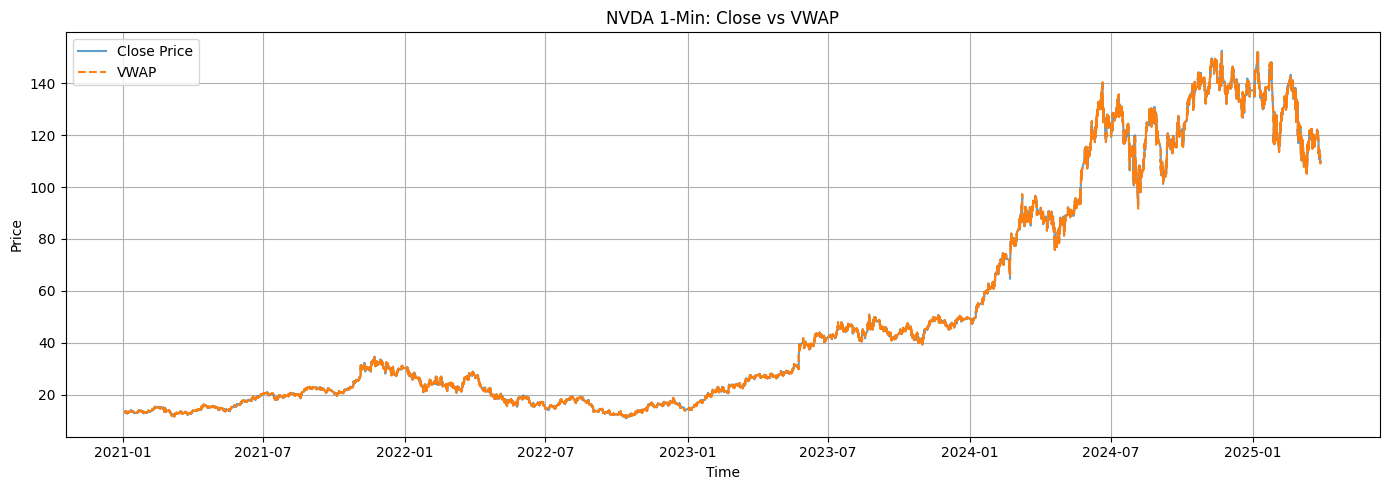

In [ ]:
# Close Price vs VWAP
plt.figure(figsize=(14, 5))
plt.plot(df_NVDA_1min_filtered_odd['close'], label='Close Price', alpha=0.7)
plt.plot(df_NVDA_1min_filtered_odd['vwap'], label='VWAP', linestyle='--')
plt.title("NVDA 1-Min: Close vs VWAP")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

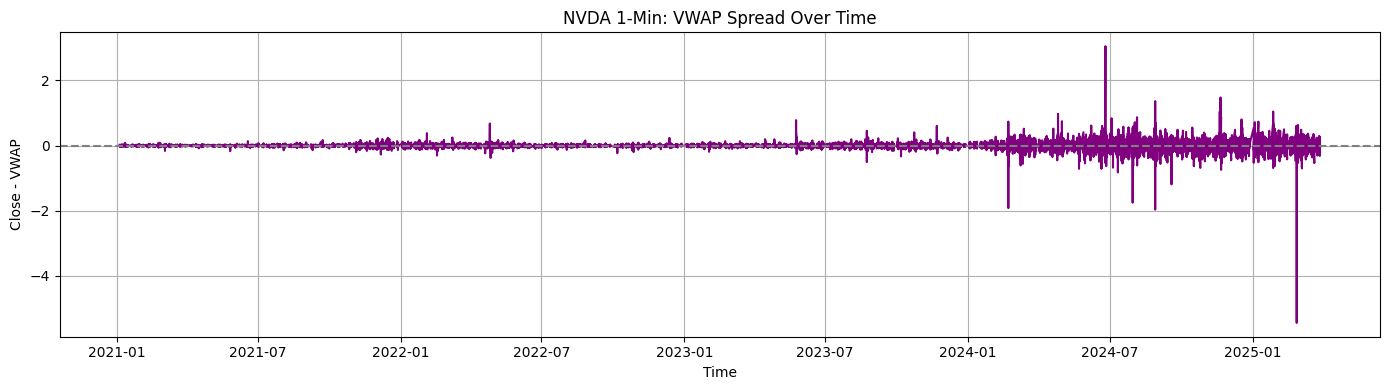

In [ ]:
#Plot 2: VWAP Spread
plt.figure(figsize=(14, 4))
plt.plot(df_NVDA_1min_filtered_odd['vwap_spread'], label='VWAP Spread', color='purple')
plt.axhline(0, color='gray', linestyle='--')
plt.title("NVDA 1-Min: VWAP Spread Over Time")
plt.xlabel("Time")
plt.ylabel("Close - VWAP")
plt.grid(True)
plt.tight_layout()
plt.show()

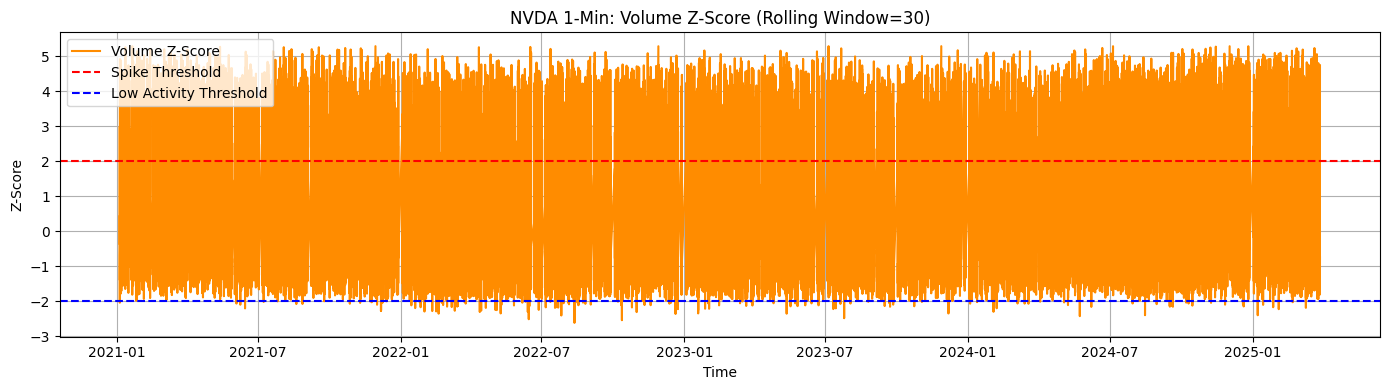

In [ ]:
#Volume Z-Score (Anomaly Detection)
plt.figure(figsize=(14, 4))
plt.plot(df_NVDA_1min_filtered_odd['volume_zscore'], label='Volume Z-Score', color='darkorange')
plt.axhline(2, color='red', linestyle='--', label='Spike Threshold')
plt.axhline(-2, color='blue', linestyle='--', label='Low Activity Threshold')
plt.title("NVDA 1-Min: Volume Z-Score (Rolling Window=30)")
plt.xlabel("Time")
plt.ylabel("Z-Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

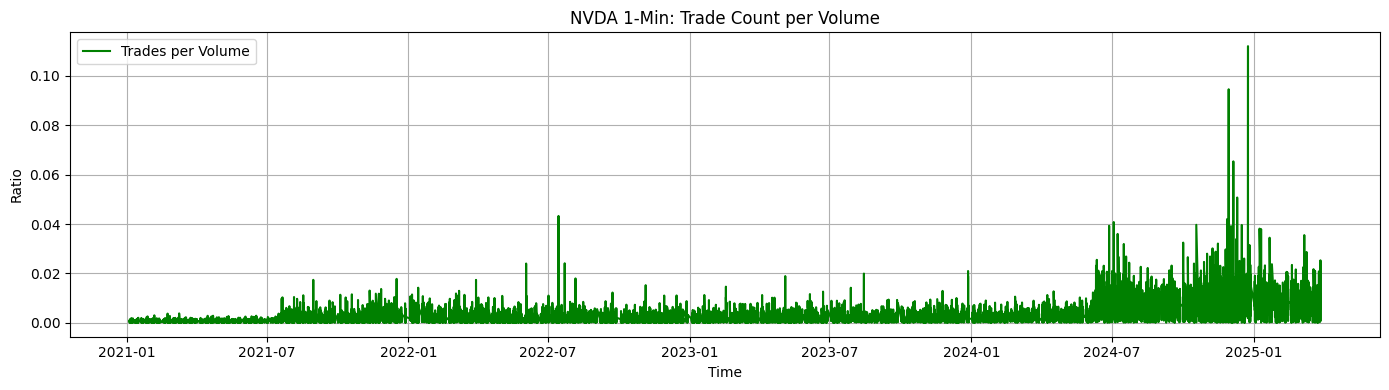

In [ ]:
#Trade Per Volume
plt.figure(figsize=(14, 4))
plt.plot(df_NVDA_1min_filtered_odd['trade_per_volume'], color='green', label='Trades per Volume')
plt.title("NVDA 1-Min: Trade Count per Volume")
plt.xlabel("Time")
plt.ylabel("Ratio")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

Base Model - LSTM

In [ ]:
# Feature Engineering 1
df_NVDA_1min_filtered_odd['price_change'] = df_NVDA_1min_filtered_odd['close'].pct_change()
df_NVDA_1min_filtered_odd['volume_change'] = df_NVDA_1min_filtered_odd['volume'].pct_change()
vol_thresh = df_NVDA_1min_filtered_odd['volume'].rolling(window=30).mean() * 0.3
count_thresh = df_NVDA_1min_filtered_odd['trade_count'].rolling(window=30).mean()

df_NVDA_1min_filtered_odd['strong_uptrend'] = ((df_NVDA_1min_filtered_odd['price_change'] > 0) & (df_NVDA_1min_filtered_odd['volume'] > vol_thresh)).astype(int)
df_NVDA_1min_filtered_odd['strong_downtrend'] = ((df_NVDA_1min_filtered_odd['price_change'] < 0) & (df_NVDA_1min_filtered_odd['volume'] > vol_thresh)).astype(int)
df_NVDA_1min_filtered_odd['weak_momentum'] = ((df_NVDA_1min_filtered_odd['volume'] < vol_thresh) & (df_NVDA_1min_filtered_odd['trade_count'] < count_thresh)).astype(int)

rolling_max = df_NVDA_1min_filtered_odd['close'].rolling(window=50).max()
df_NVDA_1min_filtered_odd['potential_reversal'] = ((df_NVDA_1min_filtered_odd['close'] > 0.98 * rolling_max) &
                            (df_NVDA_1min_filtered_odd['volume'] < vol_thresh) &
                            (df_NVDA_1min_filtered_odd['trade_count'] < count_thresh)).astype(int)

/tmp/ipython-input-41-3650552774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_1min_filtered_odd['price_change'] = df_NVDA_1min_filtered_odd['close'].pct_change()
/tmp/ipython-input-41-3650552774.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_1min_filtered_odd['volume_change'] = df_NVDA_1min_filtered_odd['volume'].pct_change()
/tmp/ipython-input-41-3650552774.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [ ]:
# Feature Engineering 2
df_NVDA_1min_filtered_odd['vwap_spread'] = df_NVDA_1min_filtered_odd['close'] - df_NVDA_1min_filtered_odd['vwap']
df_NVDA_1min_filtered_odd['price_to_vwap_ratio'] = df_NVDA_1min_filtered_odd['close'] / df_NVDA_1min_filtered_odd['vwap']
df_NVDA_1min_filtered_odd['vwap_above_flag'] = (df_NVDA_1min_filtered_odd['close'] > df_NVDA_1min_filtered_odd['vwap']).astype(int)

df_NVDA_1min_filtered_odd['rolling_volume_mean'] = df_NVDA_1min_filtered_odd['volume'].rolling(window=30).mean()
df_NVDA_1min_filtered_odd['rolling_volume_std'] = df_NVDA_1min_filtered_odd['volume'].rolling(window=30).std()
df_NVDA_1min_filtered_odd['volume_zscore'] = (df_NVDA_1min_filtered_odd['volume'] - df_NVDA_1min_filtered_odd['rolling_volume_mean']) / df_NVDA_1min_filtered_odd['rolling_volume_std']
df_NVDA_1min_filtered_odd['trade_per_volume'] = df_NVDA_1min_filtered_odd['trade_count'] / (df_NVDA_1min_filtered_odd['volume'] + 1)

# Drop temp columns and NaNs
df_NVDA_1min_filtered_odd.drop(columns=['rolling_volume_mean', 'rolling_volume_std'], inplace=True)
df_NVDA_1min_filtered_odd.dropna(inplace=True)

/tmp/ipython-input-42-2163220973.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_1min_filtered_odd['vwap_spread'] = df_NVDA_1min_filtered_odd['close'] - df_NVDA_1min_filtered_odd['vwap']
/tmp/ipython-input-42-2163220973.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_1min_filtered_odd['price_to_vwap_ratio'] = df_NVDA_1min_filtered_odd['close'] / df_NVDA_1min_filtered_odd['vwap']
/tmp/ipython-input-42-2163220973.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Kalman Filter

In [ ]:
!pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.5/145.5 kB 14.7 MB/s eta 0:00:00


In [ ]:
from pykalman import KalmanFilter

In [ ]:
def apply_kalman_filter(series):
    kf = KalmanFilter(initial_state_mean=series.iloc[0], n_dim_obs=1)
    state_means, _ = kf.smooth(series.values)
    return pd.Series(state_means.flatten(), index=series.index)

In [ ]:
# Apply Kalman filter to key features
df_NVDA_1min_filtered_odd['close_smoothed'] = apply_kalman_filter(df_NVDA_1min_filtered_odd['close'])
df_NVDA_1min_filtered_odd['vwap_smoothed'] = apply_kalman_filter(df_NVDA_1min_filtered_odd['vwap'])
df_NVDA_1min_filtered_odd['price_change_smoothed'] = apply_kalman_filter(df_NVDA_1min_filtered_odd['price_change'])

/tmp/ipython-input-46-2061724332.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_1min_filtered_odd['close_smoothed'] = apply_kalman_filter(df_NVDA_1min_filtered_odd['close'])
/tmp/ipython-input-46-2061724332.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_1min_filtered_odd['vwap_smoothed'] = apply_kalman_filter(df_NVDA_1min_filtered_odd['vwap'])
/tmp/ipython-input-46-2061724332.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [ ]:
# Apply to 2-minute dataset
df_NVDA_2min_filtered['close_smoothed'] = apply_kalman_filter(df_NVDA_2min_filtered['close'])
df_NVDA_2min_filtered['vwap_smoothed'] = apply_kalman_filter(df_NVDA_2min_filtered['vwap'])
df_NVDA_2min_filtered['price_change_smoothed'] = apply_kalman_filter(df_NVDA_2min_filtered['price_change'])

/tmp/ipython-input-47-2776586214.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_2min_filtered['close_smoothed'] = apply_kalman_filter(df_NVDA_2min_filtered['close'])
/tmp/ipython-input-47-2776586214.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_2min_filtered['vwap_smoothed'] = apply_kalman_filter(df_NVDA_2min_filtered['vwap'])
/tmp/ipython-input-47-2776586214.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

Kalman Filter vs Without comparision

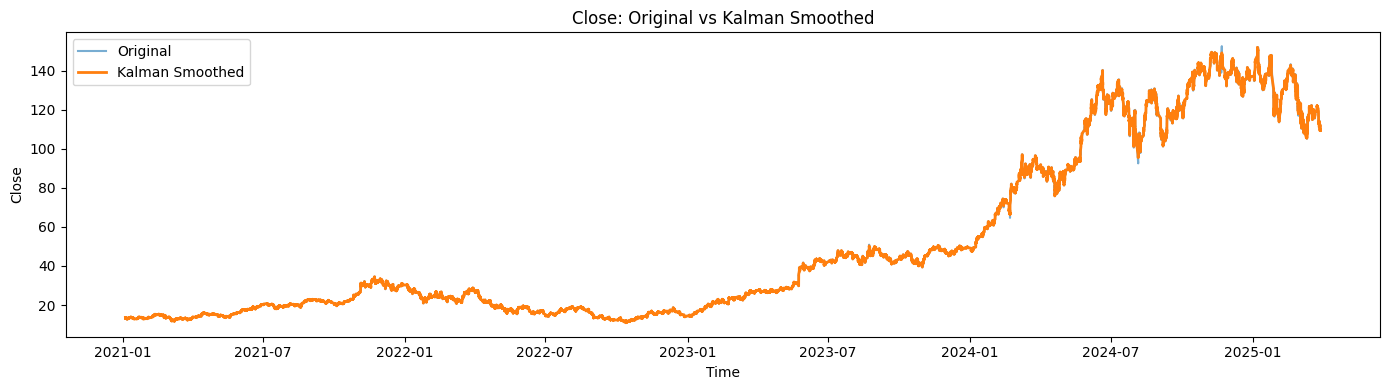

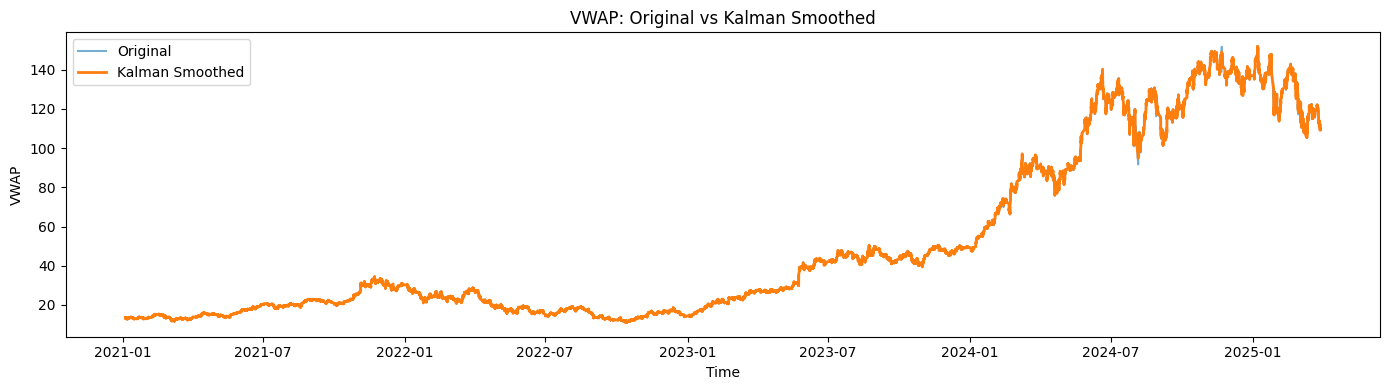

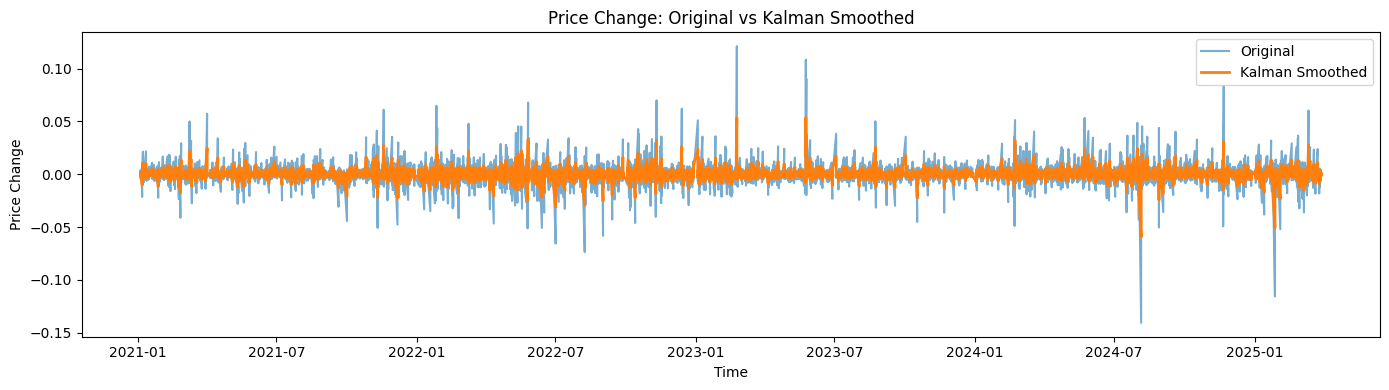

In [ ]:
# Apply to features
df_compare = df_NVDA_1min_filtered_odd.copy()
df_compare['close_smoothed'] = apply_kalman_filter(df_compare['close'])
df_compare['vwap_smoothed'] = apply_kalman_filter(df_compare['vwap'])
df_compare['price_change_smoothed'] = apply_kalman_filter(df_compare['price_change'])

# Plotting function
def plot_kalman_comparison(original, smoothed, title):
    plt.figure(figsize=(14, 4))
    plt.plot(original, label='Original', alpha=0.6)
    plt.plot(smoothed, label='Kalman Smoothed', linewidth=2)
    plt.title(f'{title}: Original vs Kalman Smoothed')
    plt.xlabel('Time')
    plt.ylabel(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run comparisons
plot_kalman_comparison(df_compare['close'], df_compare['close_smoothed'], 'Close')
plot_kalman_comparison(df_compare['vwap'], df_compare['vwap_smoothed'], 'VWAP')
plot_kalman_comparison(df_compare['price_change'], df_compare['price_change_smoothed'], 'Price Change')

In [ ]:
# Final columns for LSTM
features_1min = [
    'close_smoothed',
    'volume',
    'trade_count',
    'price_change_smoothed',
    'volume_change',
    'strong_uptrend',
    'weak_momentum',
    'vwap_spread',
    'vwap_above_flag',
    'trade_per_volume',
    'High_buy_flag',
    'High_sell_flag'
]

df_lstm_ready_1min = df_NVDA_1min_filtered_odd[features_1min].copy()

In [ ]:
df_lstm_ready_1min.head()

close_smoothed     volume  trade_count  \
timestamp                                                           
2021-01-04 10:29:00-05:00       13.604236  2689960.0       1489.0   
2021-01-04 10:31:00-05:00       13.590708  2140280.0       1139.0   
2021-01-04 10:33:00-05:00       13.583887  1949240.0       1003.0   
2021-01-04 10:35:00-05:00       13.589882  1431120.0        776.0   
2021-01-04 10:37:00-05:00       13.598758  2457320.0       1383.0   

                           price_change_smoothed  volume_change  \
timestamp                                                         
2021-01-04 10:29:00-05:00               0.001179       0.666105   
2021-01-04 10:31:00-05:00              -0.000354      -0.204345   
2021-01-04 10:33:00-05:00              -0.000257      -0.089259   
2021-01-04 10:35:00-05:00               0.000535      -0.265806   
2021-01-04 10:37:00-05:00               0.000689       0.717061   

                           strong_uptrend  weak_momentum  vwap_spread  \
timestamp                                                               
2021-01-04 10:29:00-05:00               1              0     0.012517   
2021-01-04 10:31:00-05:00               0              0    -0.007150   
2021-01-04 10:33:00-05:00               0              0     0.002538   
2021-01-04 10:35:00-05:00               1              0    -0.004261   
2021-01-04 10:37:00-05:00               1              0    -0.024393   

                           vwap_above_flag  trade_per_volume  High_buy_flag  \
timestamp                                                                     
2021-01-04 10:29:00-05:00                1          0.000554              0   
2021-01-04 10:31:00-05:00                0          0.000532              0   
2021-01-04 10:33:00-05:00                1          0.000515              0   
2021-01-04 10:35:00-05:00                0          0.000542              0   
2021-01-04 10:37:00-05:00                0          0.000563              0   

                           High_sell_flag  
timestamp                                  
2021-01-04 10:29:00-05:00               0  
2021-01-04 10:31:00-05:00               0  
2021-01-04 10:33:00-05:00               0  
2021-01-04 10:35:00-05:00               0  
2021-01-04 10:37:00-05:00               0

In [ ]:
# Run EDA on selected features
df_eda = df_lstm_ready_1min[features_1min]

eda_summary = pd.DataFrame({
    "Missing_Count": df_eda.isnull().sum(),
    "Blank_String_Count": (df_eda == '').sum(),
    "Zero_Count": (df_eda == 0).sum(),
    "One_Count": (df_eda == 1).sum(),
    "Unique_Values": df_eda.nunique(),
    "Mean": df_eda.mean(numeric_only=True),
    "Std": df_eda.std(numeric_only=True),
    "Min": df_eda.min(numeric_only=True),
    "Max": df_eda.max(numeric_only=True)
})

In [ ]:
# Display the result
print(eda_summary)

                       Missing_Count  Blank_String_Count  Zero_Count  \
close_smoothed                     0                   0           0   
volume                             0                   0           0   
trade_count                        0                   0           0   
price_change_smoothed              0                   0           0   
volume_change                      0                   0           4   
strong_uptrend                     0                   0      114428   
weak_momentum                      0                   0      202356   
vwap_spread                        0                   0        1974   
vwap_above_flag                    0                   0      108465   
trade_per_volume                   0                   0           0   
High_buy_flag                      0                   0      209934   
High_sell_flag                     0                   0      210299   

                       One_Count  Unique_Values           Mean 

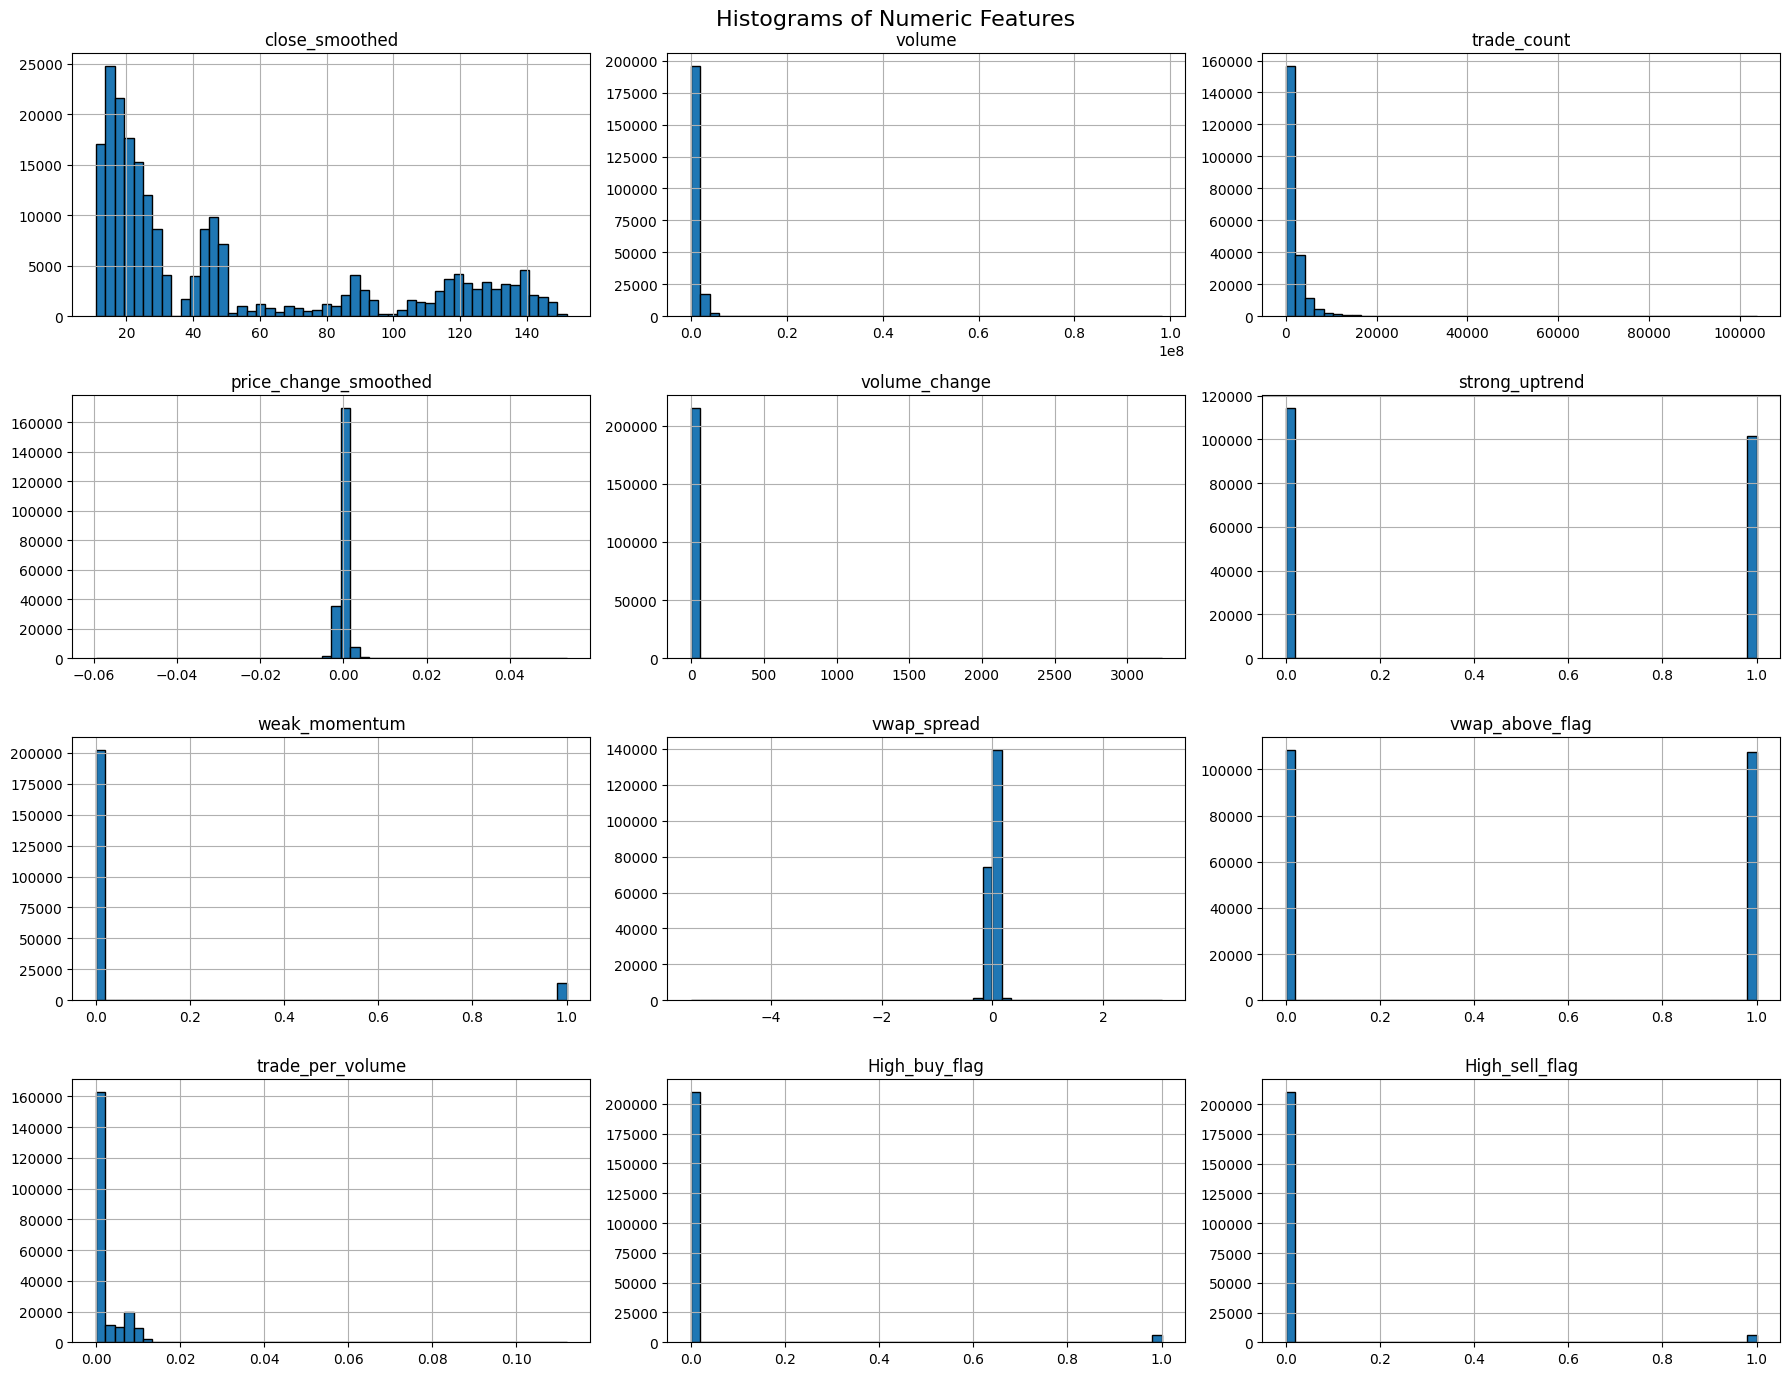

In [ ]:
numeric_cols = df_eda.select_dtypes(include='number').columns

df_eda[numeric_cols].hist(figsize=(18, 14), bins=50, edgecolor='black')
plt.suptitle("Histograms of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()

<Figure size 1600x1000 with 0 Axes>

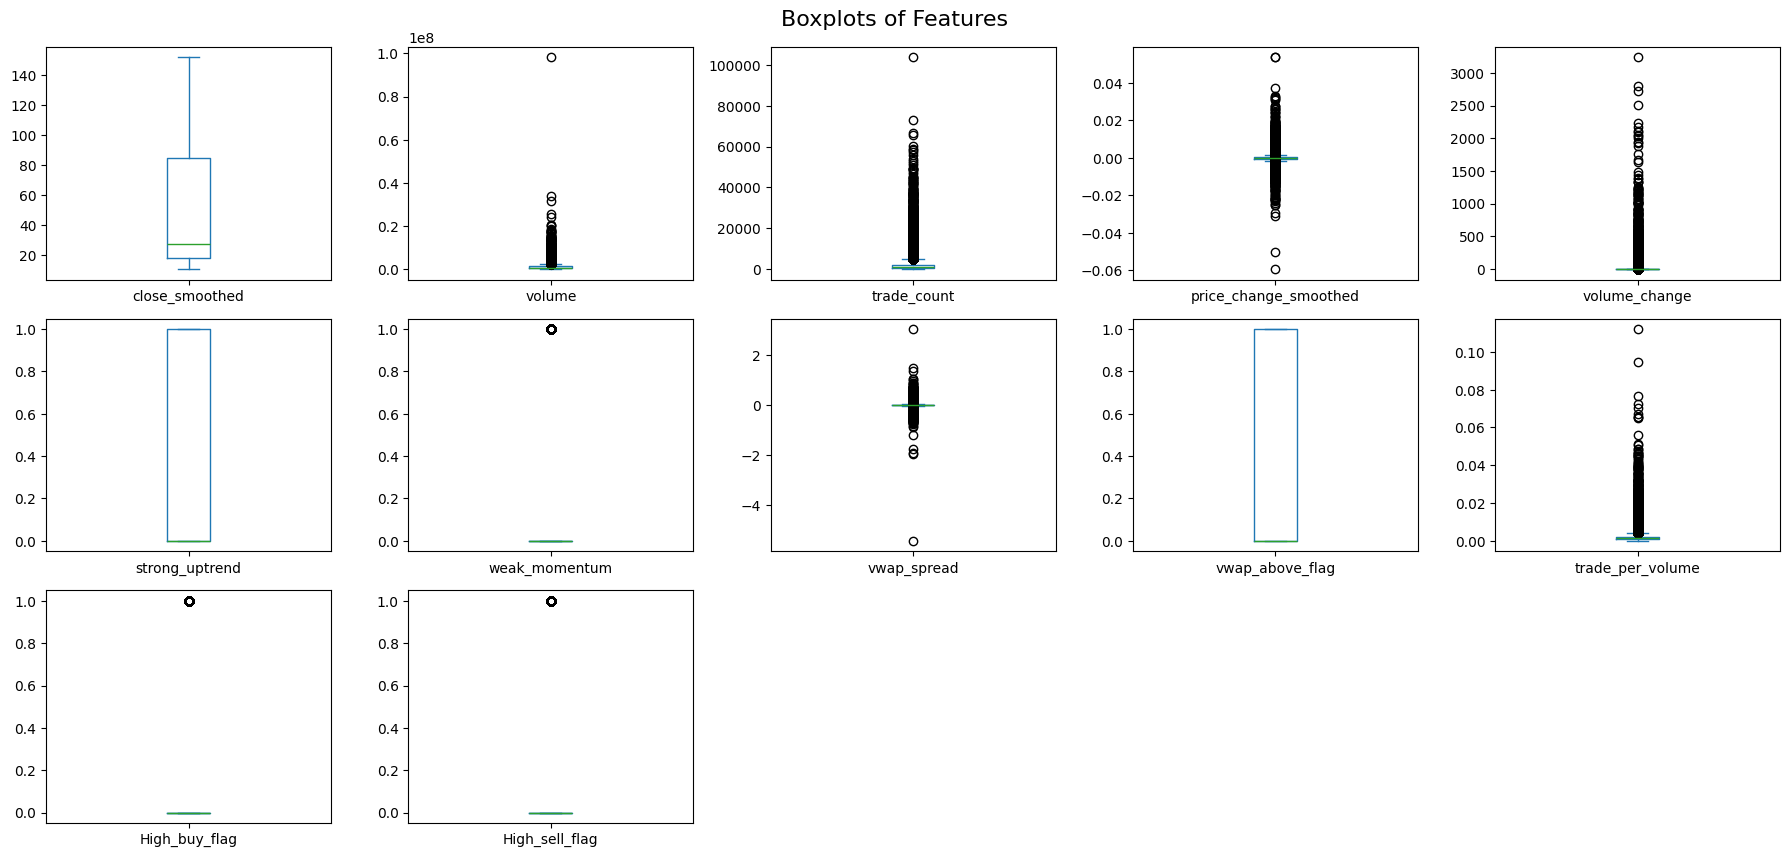

In [ ]:
plt.figure(figsize=(16, 10))
df_eda[numeric_cols].plot(kind='box', subplots=True, layout=(5, 5), figsize=(18, 14), sharex=False, sharey=False)
plt.suptitle("Boxplots of Features", fontsize=16)
plt.tight_layout()
plt.show()

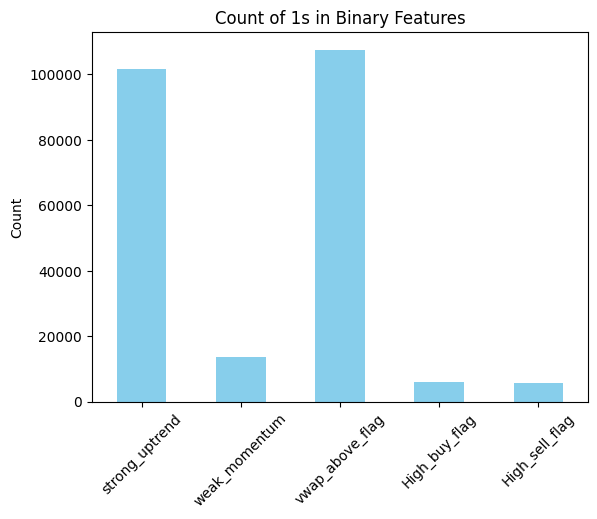

In [ ]:
binary_cols = [ 'strong_uptrend','weak_momentum',
    'vwap_above_flag',
    'High_buy_flag',
    'High_sell_flag']
df_lstm_ready_1min[binary_cols].sum().plot(kind='bar', color='skyblue')
plt.title("Count of 1s in Binary Features")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

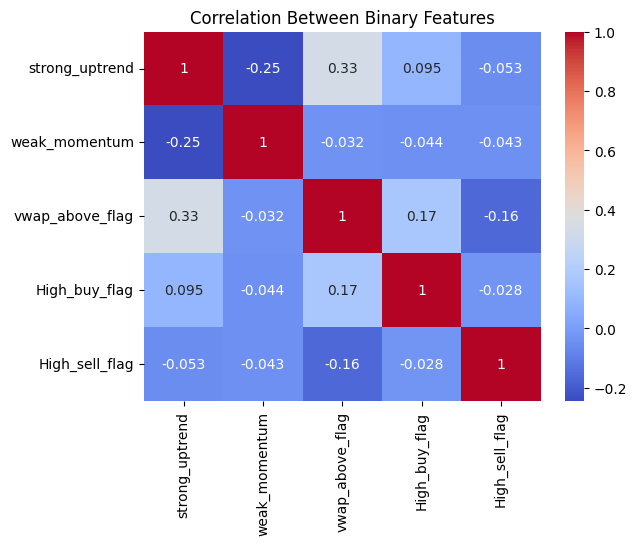

In [ ]:
sns.heatmap(df_lstm_ready_1min[binary_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Binary Features")
plt.show()

In [ ]:
# ---- Final Columns for LSTM ----
features_2min  = [
    'close_smoothed',
    'volume',
    'trade_count',
    'price_change_smoothed',
    'volume_change',
    'weak_momentum',
    'strong_uptrend',
    'weak_momentum',
    'vwap_spread',
    'vwap_above_flag',
    'trade_per_volume',
    'High_buy_flag',
    'High_sell_flag'
]

# Copy final LSTM-ready dataset
df_lstm_ready_2min = df_NVDA_2min_filtered[features_2min].copy()

In [ ]:
df_lstm_ready_2min.head()

close_smoothed     volume  trade_count  \
timestamp                                                           
2021-01-04 10:28:00-05:00       13.604236  4173000.0       2439.0   
2021-01-04 10:30:00-05:00       13.590708  7061000.0       3743.0   
2021-01-04 10:32:00-05:00       13.583887  3910960.0       2042.0   
2021-01-04 10:34:00-05:00       13.589882  3531560.0       1748.0   
2021-01-04 10:36:00-05:00       13.598758  4179640.0       2217.0   

                           price_change_smoothed  volume_change  \
timestamp                                                         
2021-01-04 10:28:00-05:00               0.001179       0.030299   
2021-01-04 10:30:00-05:00              -0.000354       0.692068   
2021-01-04 10:32:00-05:00              -0.000257      -0.446118   
2021-01-04 10:34:00-05:00               0.000535      -0.097009   
2021-01-04 10:36:00-05:00               0.000689       0.183511   

                           weak_momentum  strong_uptrend  weak_momentum  \
timestamp                                                                 
2021-01-04 10:28:00-05:00              0               1              0   
2021-01-04 10:30:00-05:00              0               0              0   
2021-01-04 10:32:00-05:00              0               0              0   
2021-01-04 10:34:00-05:00              0               1              0   
2021-01-04 10:36:00-05:00              0               1              0   

                           vwap_spread  vwap_above_flag  trade_per_volume  \
timestamp                                                                   
2021-01-04 10:28:00-05:00     0.018640                1          0.000584   
2021-01-04 10:30:00-05:00    -0.019623                0          0.000530   
2021-01-04 10:32:00-05:00    -0.004212                0          0.000522   
2021-01-04 10:34:00-05:00    -0.000551                0          0.000495   
2021-01-04 10:36:00-05:00    -0.016576                0          0.000530   

                           High_buy_flag  High_sell_flag  
timestamp                                                 
2021-01-04 10:28:00-05:00              0               0  
2021-01-04 10:30:00-05:00              0               0  
2021-01-04 10:32:00-05:00              0               0  
2021-01-04 10:34:00-05:00              0               0  
2021-01-04 10:36:00-05:00              0               0

In [ ]:
df_eda = df_lstm_ready_2min[features_2min]

eda_summary_2min = pd.DataFrame({
    "Missing_Count": df_eda.isnull().sum(),
    "Blank_String_Count": (df_eda == '').sum(),
    "Zero_Count": (df_eda == 0).sum(),
    "One_Count": (df_eda == 1).sum(),
    "Unique_Values": df_eda.nunique(),
    "Mean": df_eda.mean(numeric_only=True),
    "Std": df_eda.std(numeric_only=True),
    "Min": df_eda.min(numeric_only=True),
    "Max": df_eda.max(numeric_only=True)
})

In [ ]:
# Display the result
print(eda_summary_2min)

                       Missing_Count  Blank_String_Count  Zero_Count  \
close_smoothed                     0                   0           0   
volume                             0                   0           0   
trade_count                        0                   0           0   
price_change_smoothed              0                   0           0   
volume_change                      0                   0           7   
weak_momentum                      0                   0      192444   
weak_momentum                      0                   0      192444   
strong_uptrend                     0                   0      121362   
weak_momentum                      0                   0      192444   
weak_momentum                      0                   0      192444   
vwap_spread                        0                   0        1214   
vwap_above_flag                    0                   0      109299   
trade_per_volume                   0                   0        

EGARCH Volatility Pipeline (Standalone Version)

In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 46.2 MB/s eta 0:00:00


In [ ]:
from arch import arch_model

In [ ]:
# Step 2: Compute log returns from Kalman-smoothed close
df_lstm_ready_1min['log_return'] = np.log(df_lstm_ready_1min['close_smoothed']).diff()
df_lstm_ready_1min.dropna(inplace=True)

In [ ]:
# Step 3: Fit EGARCH(1,1) model
returns = df_lstm_ready_1min['log_return'] * 100  # scale improves convergence
egarch_model = arch_model(returns, vol='EGARCH', p=1, q=1, dist='normal')
egarch_result = egarch_model.fit(disp='off')

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01376. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [ ]:
# Step 4: Add conditional volatility to dataset
df_lstm_ready_1min['egarch_vol'] = egarch_result.conditional_volatility

In [ ]:
# Step 5: Normalize volatility and create low-volatility flag
df_lstm_ready_1min['norm_vol'] = (df_lstm_ready_1min['egarch_vol'] - df_lstm_ready_1min['egarch_vol'].min()) / \
                                 (df_lstm_ready_1min['egarch_vol'].max() - df_lstm_ready_1min['egarch_vol'].min())

In [ ]:
vol_threshold = df_lstm_ready_1min['norm_vol'].quantile(0.75)
df_lstm_ready_1min['low_vol_flag'] = df_lstm_ready_1min['norm_vol'] < vol_threshold

In [ ]:
# Step 6: Forecast 10-step ahead volatility using simulation method
egarch_forecast = egarch_result.forecast(horizon=10, method='simulation')
print("10-step ahead volatility forecast:", egarch_forecast.variance.values[-1])

10-step ahead volatility forecast: [0.00044262 0.00050679 0.0005801  0.00066225 0.00074272 0.0008188
 0.00093207 0.00101466 0.00108732 0.00127112]


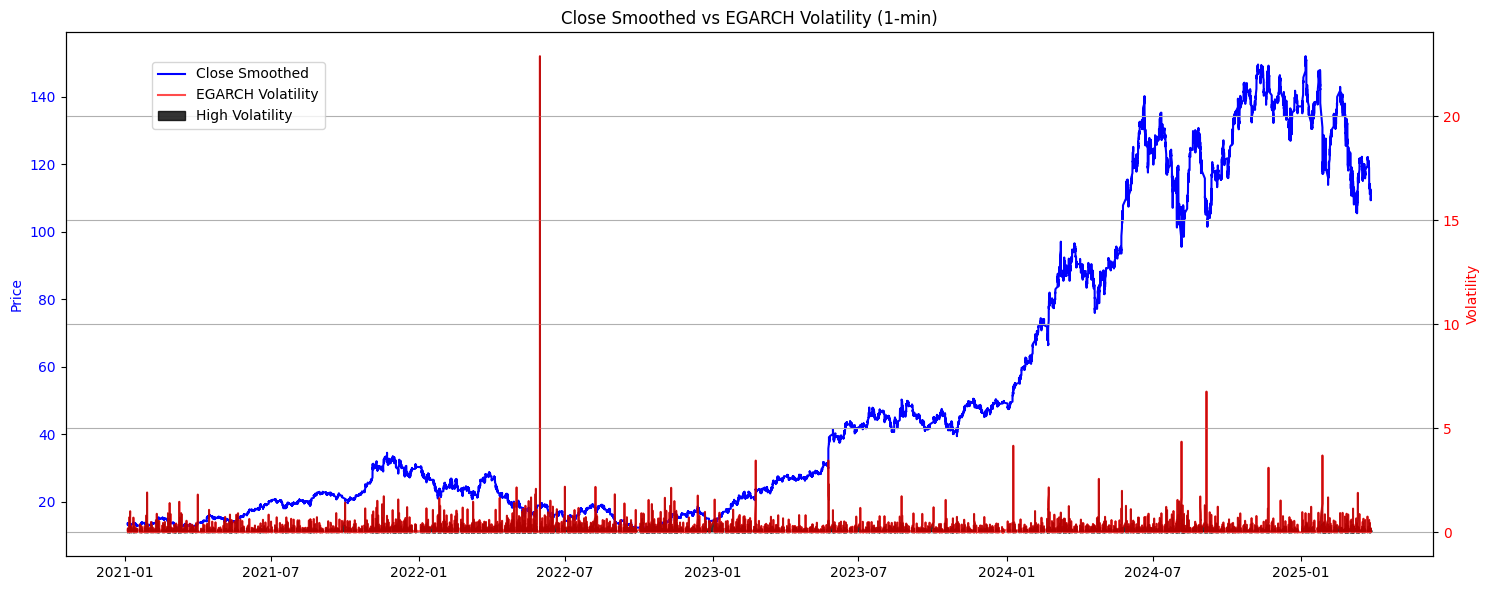

In [ ]:
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot Kalman-smoothed close price on left y-axis
ax1.plot(df_lstm_ready_1min.index, df_lstm_ready_1min['close_smoothed'], color='blue', label='Close Smoothed')
ax1.set_ylabel('Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot EGARCH volatility on right y-axis
ax2 = ax1.twinx()
vol_line, = ax2.plot(df_lstm_ready_1min.index, df_lstm_ready_1min['egarch_vol'], color='red', alpha=0.7, label='EGARCH Volatility')
ax2.set_ylabel('Volatility', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Highlight high volatility with black fill
vol_thresh_value = df_lstm_ready_1min['egarch_vol'].quantile(0.75)
high_vol = df_lstm_ready_1min['egarch_vol'] > vol_thresh_value
high_vol_fill = ax2.fill_between(
    df_lstm_ready_1min.index,
    0,
    df_lstm_ready_1min['egarch_vol'],
    where=high_vol,
    color='black',
    alpha=0.8,
    label='High Volatility'
)

# Combine legend handles
lines = [ax1.lines[0], vol_line, high_vol_fill]
labels = [line.get_label() for line in lines]

# Final formatting
plt.title('Close Smoothed vs EGARCH Volatility (1-min)')
fig.tight_layout()
fig.legend(lines, labels, loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.grid(True)
plt.show()

for 2 min

In [ ]:
#Compute log returns from Kalman-smoothed close
df_lstm_ready_2min['log_return'] = np.log(df_lstm_ready_2min['close_smoothed']).diff()
df_lstm_ready_2min.dropna(inplace=True)

In [ ]:
# Fit EGARCH(1,1) model
returns_2min = df_lstm_ready_2min['log_return'] * 100
egarch_model_2min = arch_model(returns_2min, vol='EGARCH', p=1, q=1, dist='normal')
egarch_result_2min = egarch_model_2min.fit(disp='off')

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01366. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [ ]:
# Add conditional volatility
df_lstm_ready_2min['egarch_vol'] = egarch_result_2min.conditional_volatility

# Normalize volatility and create low-vol flag
df_lstm_ready_2min['norm_vol'] = (df_lstm_ready_2min['egarch_vol'] - df_lstm_ready_2min['egarch_vol'].min()) / \
                                 (df_lstm_ready_2min['egarch_vol'].max() - df_lstm_ready_2min['egarch_vol'].min())

vol_thresh_2min = df_lstm_ready_2min['egarch_vol'].quantile(0.75)
df_lstm_ready_2min['low_vol_flag'] = df_lstm_ready_2min['egarch_vol'] < vol_thresh_2min

# Forecast 10-step ahead volatility
forecast_2min = egarch_result_2min.forecast(horizon=10, method='simulation')
print(" 2-min forecasted volatility (10 steps):", forecast_2min.variance.values[-1])

 2-min forecasted volatility (10 steps): [0.00122191 0.0019277  0.00275868 0.00349303 0.00445921 0.00532003
 0.00664933 0.00675495 0.00692963 0.00741053]


In [ ]:
# Compute log return from close_smoothed
df_lstm_ready_2min['log_return'] = np.log(df_lstm_ready_2min['close_smoothed']).diff()

# Drop NA and clip extreme returns (e.g., beyond 5 standard deviations)
df_lstm_ready_2min.dropna(inplace=True)
log_return_std = df_lstm_ready_2min['log_return'].std()
df_lstm_ready_2min = df_lstm_ready_2min[np.abs(df_lstm_ready_2min['log_return']) < (5 * log_return_std)]


In [ ]:
returns_2min = df_lstm_ready_2min['log_return'] * 100
model = arch_model(returns_2min, vol='EGARCH', p=1, q=1, dist='normal')
result = model.fit(disp='off')
df_lstm_ready_2min['egarch_vol'] = result.conditional_volatility


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008874. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [ ]:
df_lstm_ready_2min[df_lstm_ready_2min['log_return'].abs() > 1]  # or use .nlargest()


Empty DataFrame
Columns: [close_smoothed, volume, trade_count, price_change_smoothed, volume_change, weak_momentum, strong_uptrend, weak_momentum, vwap_spread, vwap_above_flag, trade_per_volume, High_buy_flag, High_sell_flag, log_return, egarch_vol, norm_vol, low_vol_flag]
Index: []

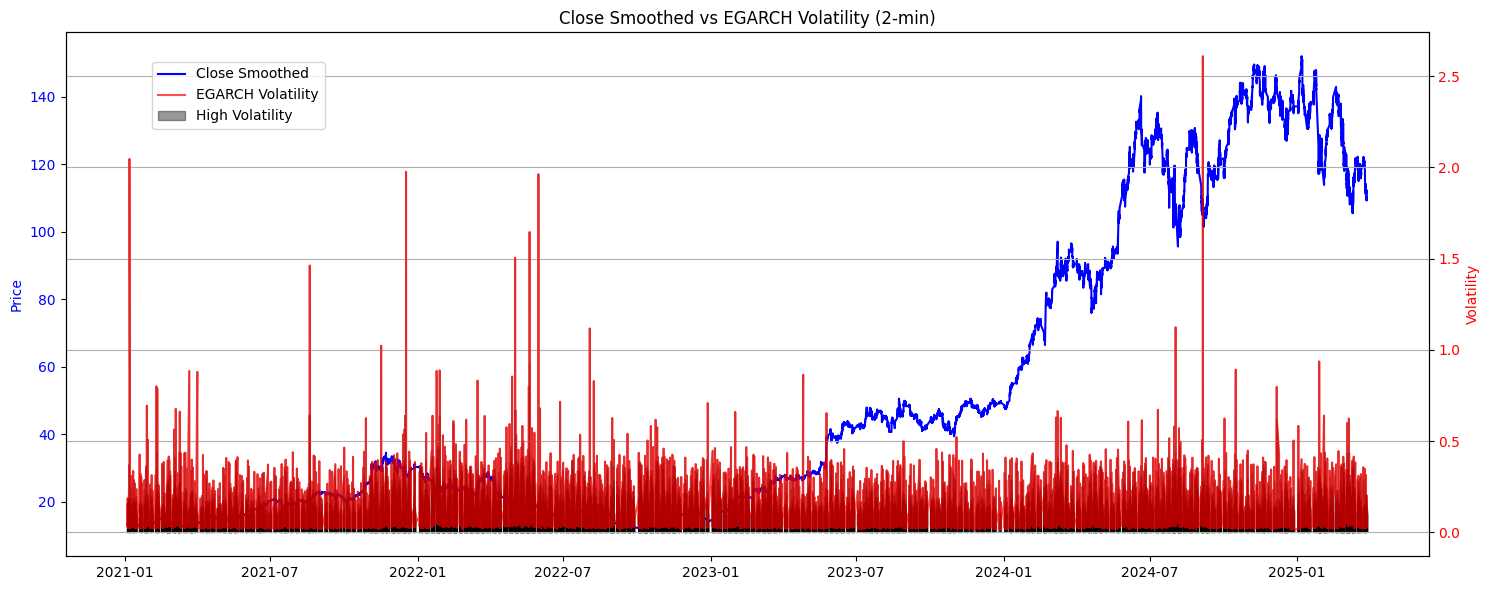

In [ ]:
# Step 6: Visualization
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot 2-min price
ax1.plot(df_lstm_ready_2min.index, df_lstm_ready_2min['close_smoothed'], color='blue', label='Close Smoothed')
ax1.set_ylabel('Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot 2-min EGARCH volatility
ax2 = ax1.twinx()
vol_line2, = ax2.plot(df_lstm_ready_2min.index, df_lstm_ready_2min['egarch_vol'], color='red', alpha=0.7, label='EGARCH Volatility')
ax2.set_ylabel('Volatility', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Fill high volatility (black)
vol_thresh_value_2min = df_lstm_ready_2min['egarch_vol'].quantile(0.75)
high_vol_2min = df_lstm_ready_2min['egarch_vol'] > vol_thresh_value_2min
high_vol_fill2 = ax2.fill_between(
    df_lstm_ready_2min.index,
    0,
    df_lstm_ready_2min['egarch_vol'],
    where=high_vol_2min,
    color='black',
    alpha=0.4,
    label='High Volatility'
)

# Combine legends
lines = [ax1.lines[0], vol_line2, high_vol_fill2]
labels = [line.get_label() for line in lines]

# Final layout
plt.title('Close Smoothed vs EGARCH Volatility (2-min)')
fig.tight_layout()
fig.legend(lines, labels, loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.grid(True)
plt.show()

In [ ]:
# Helper function to compute and plot correlation matrix
def plot_correlation_heatmap(df, title):
    plt.figure(figsize=(16, 10))
    corr_matrix = df.corr(numeric_only=True)
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
# Helper function to perform PCA
def run_pca(df, title, n_components=5):
    numeric_df = df.select_dtypes(include='number').dropna()
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_df)

    pca = PCA(n_components=n_components)
    pca_components = pca.fit_transform(scaled_data)

    explained_variance = pca.explained_variance_ratio_
    cum_variance = explained_variance.cumsum()

    # Scree plot
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, n_components + 1), cum_variance, marker='o', linestyle='--', color='green')
    plt.title(f'Cumulative Explained Variance (PCA): {title}')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pca, scaler

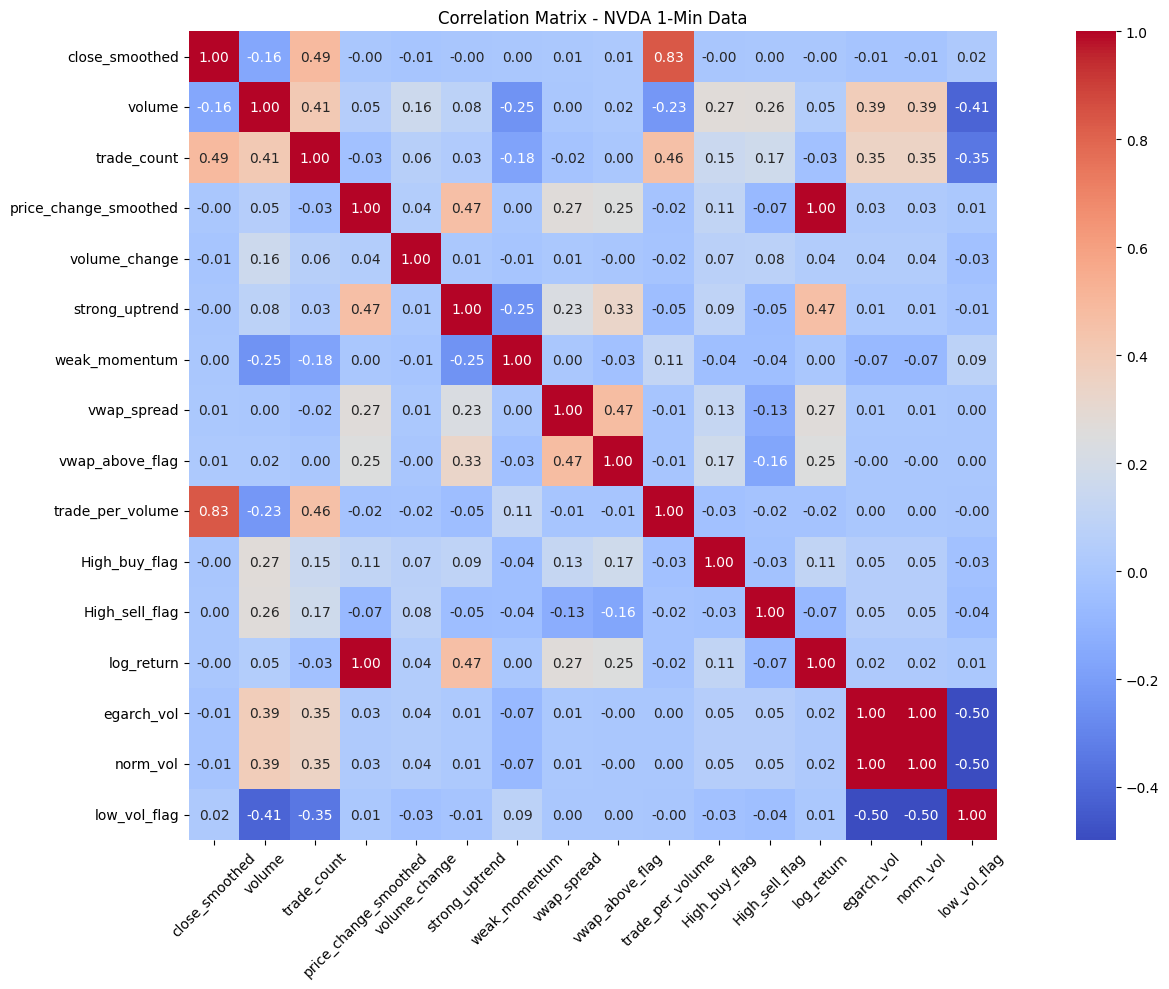

In [ ]:
# --- Run for 1-min data ---
plot_correlation_heatmap(df_lstm_ready_1min, "Correlation Matrix - NVDA 1-Min Data")


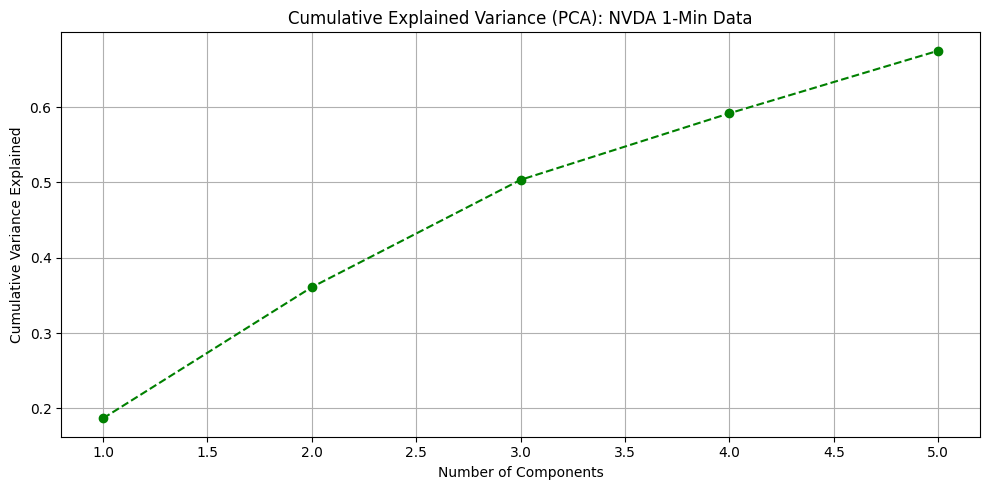

In [ ]:
pca1, scaler1 = run_pca(df_lstm_ready_1min, "NVDA 1-Min Data")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


/tmp/ipython-input-82-2739423851.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature', palette='viridis')


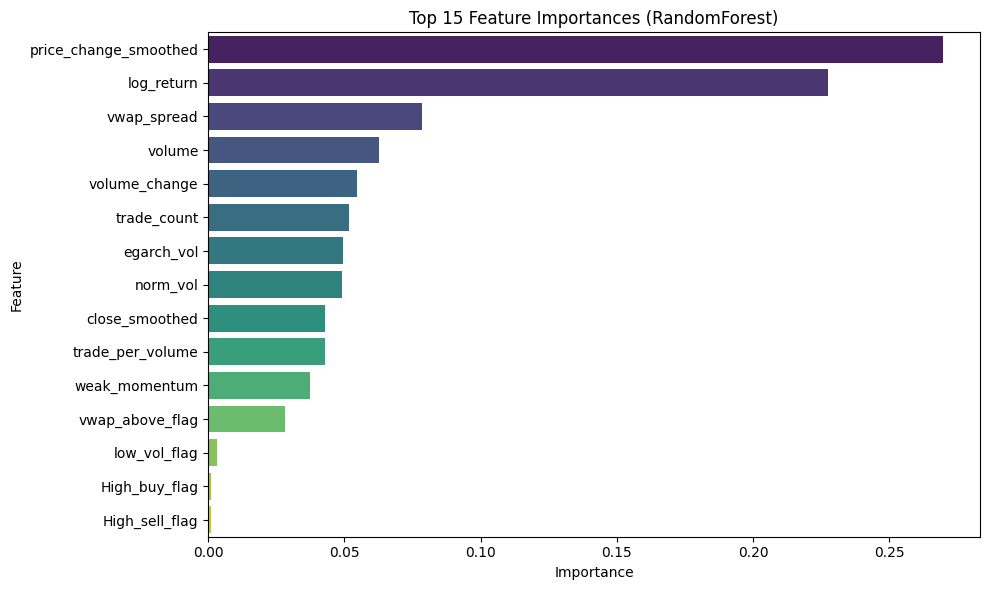

In [ ]:
# Ensure target column exists
if 'strong_uptrend' not in df_lstm_ready_1min.columns:
    df_lstm_ready_1min['strong_uptrend'] = df_NVDA_1min_filtered_odd['strong_uptrend']

# Drop timestamp columns
df = df_lstm_ready_1min.drop(columns=['year', 'month', 'day', 'hour', 'minute'], errors='ignore')

# Define target and features
X = df.drop(columns=['strong_uptrend'])
y = df['strong_uptrend']

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Train RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled_df, y)

# Plot feature importances
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (RandomForest)')
plt.tight_layout()
plt.show()


Adding attention Mechanism

In [ ]:
# --- Imports ---
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, precision_recall_curve, auc
)
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
# --- Features ---
features = [
    'close_smoothed', 'volume', 'trade_count', 'price_change_smoothed', 'volume_change','weak_momentum', 'vwap_spread', 'vwap_above_flag', 'trade_per_volume', 'High_buy_flag', 'High_sell_flag', 'egarch_vol', 'low_vol_flag',
]

SEQ_LEN = 30
TARGET_COL = 'strong_uptrend'

In [ ]:
# --- Attention Layer ---
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer="normal", trainable=True)
        self.b = self.add_weight(shape=(1,), initializer="zeros", trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(inputs, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = tf.keras.backend.sum(inputs * a, axis=1)
        return output

In [ ]:
# --- Build Model ---
def build_lstm_attention_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # 4 BiLSTM layers with decreasing units
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(inputs)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(x)

    # Attention mechanism
    x = AttentionLayer()(x)

    # Output layer
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Build and compile model
    model = tf.keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Model summary
model = build_lstm_attention_model((SEQ_LEN, len(features)))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 13)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 30, 256)        │       145,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 30, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 30, 64)         │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 64)             │            65 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 449,922 (1.72 MB)

 Trainable params: 449,922 (1.72 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- Sequence Prep ---
def create_sequences(X, y, seq_len=30):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i - seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

In [ ]:
# If the label is completely missing, extract from original filtered df
if 'strong_uptrend' not in df_lstm_ready_1min.columns or df_lstm_ready_1min['strong_uptrend'].isna().all():
    if 'strong_uptrend' in df_NVDA_1min_filtered.columns:
        df_lstm_ready_1min['strong_uptrend'] = df_NVDA_1min_filtered['strong_uptrend']
    else:
        raise ValueError("strong_uptrend label not found in either dataframe.")

df_NVDA_1min_filtered['strong_uptrend'] = df_lstm_ready_1min['strong_uptrend']
df_NVDA_2min_filtered['strong_uptrend'] = df_lstm_ready_2min['strong_uptrend']

# 2. Reset index on both to make sure alignment works
df = df_lstm_ready_1min.reset_index(drop=False)
filtered_df = df_NVDA_1min_filtered.reset_index(drop=False)

# 3. Add target label into df
df['strong_uptrend'] = filtered_df['strong_uptrend']

# Only needed once before training
df_lstm_ready_1min['strong_uptrend'] = df_NVDA_1min_filtered_odd['strong_uptrend']

df_lstm_ready_2min['strong_uptrend'] = df_NVDA_2min_filtered['strong_uptrend']


/tmp/ipython-input-89-3167060194.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_1min_filtered['strong_uptrend'] = df_lstm_ready_1min['strong_uptrend']
/tmp/ipython-input-89-3167060194.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_2min_filtered['strong_uptrend'] = df_lstm_ready_2min['strong_uptrend']


In [ ]:
# Print label distribution to confirm classes are balanced
print("Label distribution:", np.unique(df['strong_uptrend'], return_counts=True))

Label distribution: (array([nan]), array([216035]))


In [ ]:
# Label and featues
#df_lstm_ready_1min.dropna(subset=features + ['strong_uptrend'], inplace=True)

#df_lstm_ready_2min.dropna(subset=features + ['strong_uptrend'], inplace=True)


In [ ]:
X_df_1min = df_lstm_ready_1min[features]  # ✅ keep as DataFrame
y_raw = df_lstm_ready_1min['strong_uptrend'].values

X_df_2min = df_lstm_ready_2min[features]
y_raw_2min = df_lstm_ready_2min['strong_uptrend'].values

In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
# 7. Normalize features for both 1 and 2 min
#scaler = MinMaxScaler()
#X_scaled = scaler.fit_transform(X_df_1min)

#scaler_2min = MinMaxScaler()
#X_scaled_2min = scaler_2min.fit_transform(X_df_2min)

In [ ]:
# Normalize features for both 1 and 2 min
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_df_1min)

scaler_2min = RobustScaler()
X_scaled_2min = scaler_2min.fit_transform(X_df_2min)

In [ ]:
import joblib

In [ ]:
joblib.dump(scaler_2min, "NVDA_scaler_2min.pkl")

['NVDA_scaler_2min.pkl']

In [ ]:
# Create sequences for both 1 min and 2 min
X_seq_1min, y_seq_1min = create_sequences(X_scaled, y_raw, seq_len=30)

X_seq_2min, y_seq_2min = create_sequences(X_scaled_2min, y_raw_2min, seq_len=30)

In [ ]:
# Split into training and testing sets
X_train_1min, X_test_1min, y_train_1min, y_test_1min = train_test_split(X_seq_1min, y_seq_1min, test_size=0.2, shuffle=False)

X_train_2min, X_test_2min, y_train_2min, y_test_2min = train_test_split(
    X_seq_2min, y_seq_2min, test_size=0.2, shuffle=False)

# 11. Compute class weights
cw = dict(enumerate(
    class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_1min), y=y_train_1min)
))

cw = dict(enumerate(
    class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_2min), y=y_train_2min)
))

In [ ]:
# Build and compile the model
input_shape = (X_train_1min.shape[1], X_train_1min.shape[2])
model_1min = build_lstm_attention_model(input_shape)

input_shape_2min = (X_train_2min.shape[1], X_train_2min.shape[2])
model_2min = build_lstm_attention_model(input_shape_2min)


In [ ]:
# Train model
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
class_weights_1min = dict(enumerate(
    class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_1min), y=y_train_1min)
))

In [ ]:
def evaluate_model(model, history, X_test, y_test, label='Model'):
    y_probs = model.predict(X_test).flatten()
    y_pred = (y_probs > 0.6).astype(int)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_probs)
    mae = mean_absolute_error(y_test, y_probs)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n🔍 {label} Evaluation:")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC AUC: {roc_auc:.4f} | MAE: {mae:.4f}")

    # Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{label} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Training history
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{label} - Loss Curve')
    plt.legend()
    plt.show()

    # PR Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall_vals, precision_vals)
    plt.figure(figsize=(6, 4))
    plt.plot(recall_vals, precision_vals, label=f'PR AUC={pr_auc:.4f}')
    plt.title(f'{label} - Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

In [ ]:
history_1min = model_1min.fit(
    X_train_1min, y_train_1min,
    validation_data=(X_test_1min, y_test_1min),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    class_weight=class_weights_1min
)

Epoch 1/30
2701/2701 ━━━━━━━━━━━━━━━━━━━━ 60s 19ms/step - accuracy: 0.5943 - loss: 0.6474 - val_accuracy: 0.6093 - val_loss: 0.6710
Epoch 2/30
2701/2701 ━━━━━━━━━━━━━━━━━━━━ 51s 19ms/step - accuracy: 0.6499 - loss: 0.6067 - val_accuracy: 0.6334 - val_loss: 0.6513
Epoch 3/30
2701/2701 ━━━━━━━━━━━━━━━━━━━━ 51s 19ms/step - accuracy: 0.6573 - loss: 0.6022 - val_accuracy: 0.6458 - val_loss: 0.6176
Epoch 4/30
2701/2701 ━━━━━━━━━━━━━━━━━━━━ 51s 19ms/step - accuracy: 0.6663 - loss: 0.5942 - val_accuracy: 0.6450 - val_loss: 0.6208
Epoch 5/30
2701/2701 ━━━━━━━━━━━━━━━━━━━━ 51s 19ms/step - accuracy: 0.6689 - loss: 0.5905 - val_accuracy: 0.6379 - val_loss: 0.6340
Epoch 6/30
2701/2701 ━━━━━━━━━━━━━━━━━━━━ 53s 20ms/step - accuracy: 0.6716 - loss: 0.5867 - val_accuracy: 0.6424 - val_loss: 0.6305
Epoch 7/30
2701/2701 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - accuracy: 0.6720 - loss: 0.5857 - val_accuracy: 0.6418 - val_loss: 0.6339
Epoch 8/30
2701/2701 ━━━━━━━━━━━━━━━━━━━━ 51s 19ms/step - accuracy: 0.6782 -

In [ ]:
class_weights_2min = dict(enumerate(
    class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_2min), y=y_train_2min)
))

In [ ]:
history_2min = model_2min.fit(
    X_train_2min, y_train_2min,
    validation_data=(X_test_2min, y_test_2min),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    class_weight=class_weights_2min
)

Epoch 1/30
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.6121 - loss: 0.6312 - val_accuracy: 0.5976 - val_loss: 0.6934
Epoch 2/30
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 51s 19ms/step - accuracy: 0.6916 - loss: 0.5656 - val_accuracy: 0.6553 - val_loss: 0.5965
Epoch 3/30
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 51s 19ms/step - accuracy: 0.7004 - loss: 0.5555 - val_accuracy: 0.6656 - val_loss: 0.5957
Epoch 4/30
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 51s 19ms/step - accuracy: 0.7010 - loss: 0.5552 - val_accuracy: 0.6120 - val_loss: 0.6666
Epoch 5/30
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 51s 19ms/step - accuracy: 0.7017 - loss: 0.5522 - val_accuracy: 0.6812 - val_loss: 0.5828
Epoch 6/30
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 51s 19ms/step - accuracy: 0.7062 - loss: 0.5480 - val_accuracy: 0.6643 - val_loss: 0.6033
Epoch 7/30
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 51s 19ms/step - accuracy: 0.7102 - loss: 0.5434 - val_accuracy: 0.6917 - val_loss: 0.5717
Epoch 8/30
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 51s 19ms/step - accuracy: 0.7098 -

In [ ]:
from sklearn.metrics import mean_absolute_error


1351/1351 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

🔍 LSTM + Attention (1-min) Evaluation:
Accuracy: 0.6476 | Precision: 0.6577 | Recall: 0.5142 | F1: 0.5772 | ROC AUC: 0.7165 | MAE: 0.4089


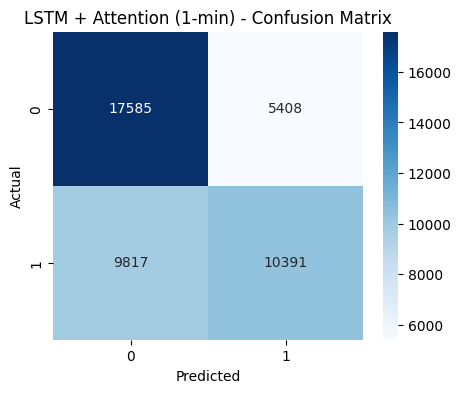

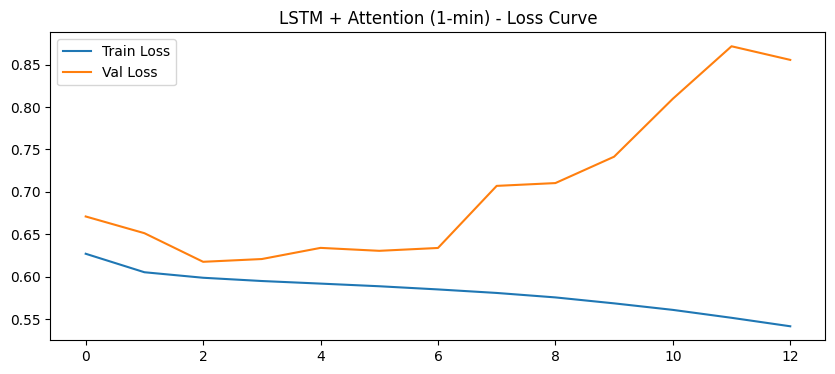

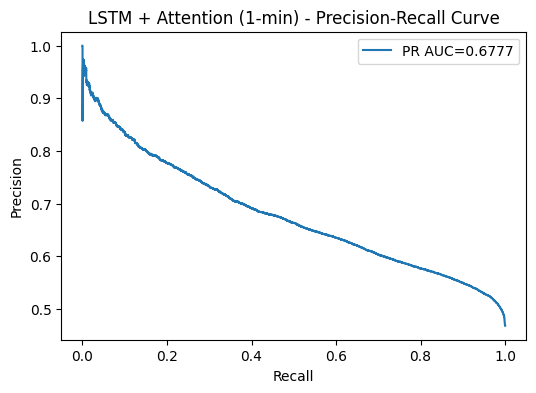

In [ ]:
## -- Evaluate -- 1 min --
evaluate_model(model_1min, history_1min, X_test_1min, y_test_1min, label="LSTM + Attention (1-min)")


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

🔍 LSTM + Attention (2-min) Evaluation:
Accuracy: 0.6764 | Precision: 0.7210 | Recall: 0.4537 | F1: 0.5569 | ROC AUC: 0.7647 | MAE: 0.3822


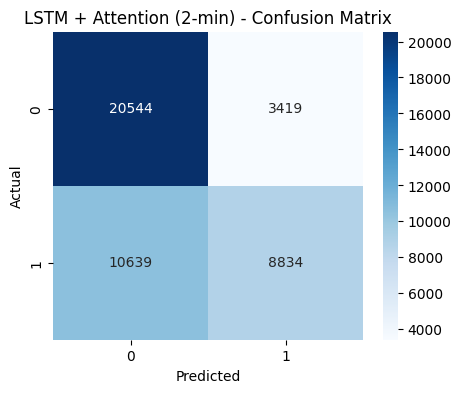

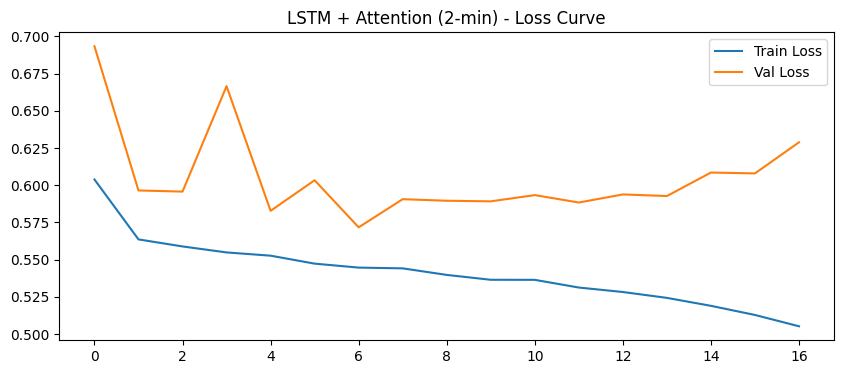

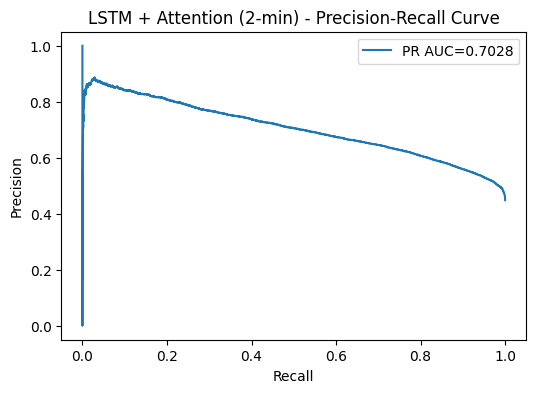

In [ ]:
# --- Evaluate - 2min ---
evaluate_model(model_2min, history_2min, X_test_2min, y_test_2min, label="LSTM + Attention (2-min)")


Save the model

In [ ]:
!pip install alpaca-trade-api

In [ ]:

#from alpaca_trade_api.rest import REST
from datetime import datetime, timedelta

# Define save path
save_dir = "/content/drive/MyDrive/Colab_Notebooks/WS_Bull_Trained_Model/NVDA_EGARCH_Kalman_4layers_LSTM"

# Create directory
import os
os.makedirs(save_dir, exist_ok=True)

In [ ]:
# --- Save 1-minute artifacts ---
model_1min.save(os.path.join(save_dir, "NVDA_model_1min.keras"))
joblib.dump(X_scaled, os.path.join(save_dir, "NVDA_scaler_1min.pkl"))

# --- Save 2-minute artifacts ---
model_2min.save(os.path.join(save_dir, "NVDA_model_2min.keras"))
joblib.dump(X_scaled_2min, os.path.join(save_dir, "NVDA_scaler_2min.pkl"))

['/content/drive/MyDrive/Colab_Notebooks/WS_Bull_Trained_Model/NVDA_EGARCH_Kalman_4layers_LSTM/NVDA_scaler_2min.pkl']

In [ ]:
model_1min.save('/content/drive/MyDrive/Colab_Notebooks/WS_Bull_Trained_Model/NVDA_EGARCH_Kalman_4layers_LSTM_1min.keras')
model_2min.save('/content/drive/MyDrive/Colab_Notebooks/WS_Bull_Trained_Model/NVDA_EGARCH_Kalman_4layers_LSTM_2min.keras')



Back Testing

In [ ]:
from google.colab import userdata

API_KEY    = userdata.get("APCA_API_KEY_ID")
API_SECRET = userdata.get("APCA_API_SECRET_KEY")
BASE_URL   = userdata.get("ALPACA_BASE_URL")

# Quick sanity check:
if not (API_KEY and API_SECRET and BASE_URL):
    raise RuntimeError("One of your Alpaca secrets is missing!")

import alpaca_trade_api as tradeapi
api = tradeapi.REST(API_KEY, API_SECRET, BASE_URL, api_version="v2")

In [ ]:
import alpaca_trade_api as tradeapi

In [ ]:
API_KEY    = "YOUR_API"
API_SECRET = "YOUR_SECRET"
BASE_URL   = "https://paper-api.alpaca.markets"

api = tradeapi.REST(API_KEY, API_SECRET, BASE_URL, api_version="v2")

In [ ]:
START_DATE = "2025-04-01"
END_DATE   = "2025-06-13"

bars = api.get_bars(
    "TSLA",
    timeframe="1Min",
    start=START_DATE,
    end=END_DATE,
).df

bars = bars.tz_convert("America/New_York").reset_index()
bars.rename(columns={"timestamp":"timestamp"}, inplace=True)
print(bars.head())

                  timestamp   close    high     low  trade_count    open  \
0 2025-04-01 04:00:00-04:00  265.43  265.48  262.27         1053  264.00   
1 2025-04-01 04:01:00-04:00  266.52  267.06  265.15         1067  265.24   
2 2025-04-01 04:02:00-04:00  268.69  269.08  266.87         1717  266.87   
3 2025-04-01 04:03:00-04:00  269.40  269.40  268.00         1460  268.82   
4 2025-04-01 04:04:00-04:00  268.49  269.49  268.42         1028  269.40   

   volume        vwap  
0   50312  263.951643  
1   52063  266.087695  
2   93101  268.228186  
3   89172  268.640777  
4   85783  268.986750  


In [ ]:
def engineer_features_live(df):
    df = df.copy()
    df['close_smoothed'] = df['close'].rolling(3, min_periods=1).mean()  # Quick smoothing
    df['price_change_smoothed'] = df['close_smoothed'].pct_change()
    df['volume_change'] = df['volume'].pct_change()
    df['vwap_spread'] = df['close'] - df['vwap']
    df['vwap_above_flag'] = (df['close'] > df['vwap']).astype(int)
    df['trade_per_volume'] = df['trade_count'] / (df['volume'] + 1)
    df['High_buy_flag'] = ((df['vwap_above_flag']==1) & (df['volume'] > df['volume'].rolling(30).mean()*2) & (df['trade_per_volume']<0.1)).astype(int)
    df['High_sell_flag'] = ((df['vwap_above_flag']==0) & (df['volume'] > df['volume'].rolling(30).mean()*2) & (df['trade_per_volume']<0.1)).astype(int)
    df['weak_momentum'] = ((df['volume'] < df['volume'].rolling(30).mean()*0.3) & (df['trade_count'] < df['trade_count'].rolling(30).mean())).astype(int)
    # Drop NaNs that may have appeared
    df = df.dropna().reset_index(drop=True)
    return df

In [ ]:
# Features order MUST match model training
features_NVDA = [
    'close_smoothed', 'volume', 'trade_count', 'price_change_smoothed', 'volume_change','weak_momentum', 'vwap_spread', 'vwap_above_flag', 'trade_per_volume', 'High_buy_flag', 'High_sell_flag', 'egarch_vol', 'low_vol_flag',
]


SEQ_LEN = 30

# --- Apply Feature Engineering ---
feat = engineer_features_live(bars)



In [ ]:
feat['egarch_vol'] = feat.get('egarch_vol', 0)
feat['weak_momentum'] = feat.get('weak_momentum', 0)
feat['low_vol_flag'] = feat.get('low_vol_flag', 0)

# --- Use only required features ---
X_live = feat[features_NVDA].values
X_live_scaled = scaler.transform(X_live)

# --- Generate rolling sequences for backtest ---
def create_sequences(X, seq_len=30):
    return np.array([X[i-seq_len:i] for i in range(seq_len, len(X))])

X_seq = create_sequences(X_live_scaled, seq_len=SEQ_LEN)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [ ]:
# --- Predict ---
probs = model_1min.predict(X_seq).flatten()
signals = (probs > 0.8).astype(int)

# --- Create Results DataFrame ---
result_df = feat.iloc[SEQ_LEN:].copy().reset_index(drop=True)
result_df['prob'] = probs
result_df['signal'] = signals
print(result_df[['timestamp','prob','signal']].head(10))
print("Total Buy Signals:", result_df['signal'].sum())

1549/1549 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
                  timestamp      prob  signal
0 2025-04-01 04:31:00-04:00  0.126305       0
1 2025-04-01 04:32:00-04:00  0.027125       0
2 2025-04-01 04:33:00-04:00  0.029703       0
3 2025-04-01 04:34:00-04:00  0.040400       0
4 2025-04-01 04:35:00-04:00  0.021696       0
5 2025-04-01 04:36:00-04:00  0.070471       0
6 2025-04-01 04:37:00-04:00  0.051156       0
7 2025-04-01 04:38:00-04:00  0.086735       0
8 2025-04-01 04:39:00-04:00  0.036988       0
9 2025-04-01 04:40:00-04:00  0.024200       0
Total Buy Signals: 3805


Total Buy Signals: 3805


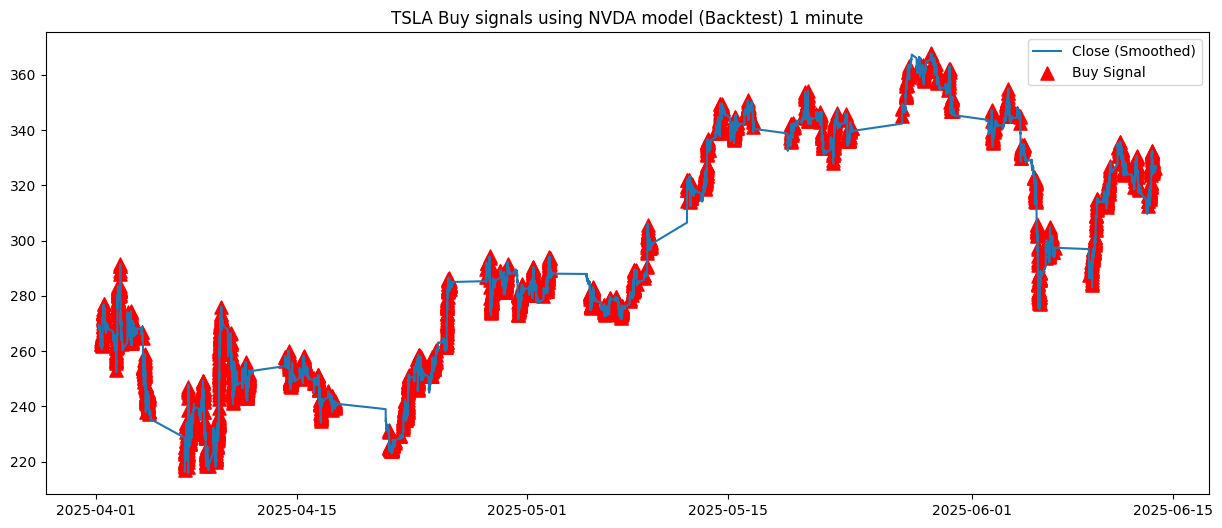

In [ ]:
print("Total Buy Signals:", result_df['signal'].sum())
plt.figure(figsize=(15,6))
plt.plot(result_df['timestamp'], result_df['close_smoothed'], label='Close (Smoothed)')
plt.scatter(result_df.loc[result_df['signal']==1, 'timestamp'], result_df.loc[result_df['signal']==1, 'close_smoothed'], color='red', s=90, marker='^', label='Buy Signal')
plt.legend()
plt.title('TSLA Buy signals using NVDA model (Backtest) 1 minute')
plt.show()

In [ ]:
START_DATE = "2025-04-01"
END_DATE   = "2025-06-13"

bars_2min = api.get_bars(
    "TSLA",
    timeframe="2Min",
    start=START_DATE,
    end=END_DATE,
).df

bars_2min = bars_2min.tz_convert("America/New_York").reset_index()
bars_2min.rename(columns={"timestamp":"timestamp"}, inplace=True)
print(bars_2min.head())

                  timestamp   close    high     low  trade_count    open  \
0 2025-04-01 04:00:00-04:00  266.52  267.06  262.27         2120  264.00   
1 2025-04-01 04:02:00-04:00  269.40  269.40  266.87         3177  266.87   
2 2025-04-01 04:04:00-04:00  268.62  269.49  268.11         1668  269.40   
3 2025-04-01 04:06:00-04:00  269.99  269.99  268.60         1548  268.66   
4 2025-04-01 04:08:00-04:00  270.30  271.08  269.65         2440  269.93   

   volume        vwap  
0  102375  265.076179  
1  182273  268.443970  
2  111257  268.905534  
3   67374  269.254467  
4  100386  270.103345  


In [ ]:
import joblib

scaler_2min = joblib.load("/content/drive/MyDrive/Colab_Notebooks/WS_Bull_Trained_Model/NVDA_EGARCH_Kalman_4layers_LSTM/NVDA_scaler_2min.pkl")

In [ ]:
joblib.dump(scaler_2min, 'scaler_input_features.pkl')

['scaler_input_features.pkl']

In [ ]:
feat_2min = engineer_features_live(bars_2min)

feat_2min['strong_uptrend'] = 0
feat_2min['egarch_vol'] = 0
feat_2min['egarch_forecast'] = 0

In [ ]:
features_2min = [
    'close_smoothed', 'volume', 'trade_count', 'price_change_smoothed', 'volume_change',
    'weak_momentum', 'strong_uptrend', 'vwap_spread', 'vwap_above_flag',
    'trade_per_volume', 'High_buy_flag', 'High_sell_flag',
    'egarch_vol', 'egarch_forecast'
]


In [ ]:
def create_sequences(X, seq_len=30):
    return np.array([X[i-seq_len:i] for i in range(seq_len, len(X))])

In [ ]:
scaler_2min = joblib.load("NVDA_scaler_2min.pkl")
X_live_2min = feat_2min[features_2min].values
X_live_2min_scaled = scaler_2min.transform(X_live_2min)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [ ]:
def create_sequences(X, seq_len=30):
    # Output shape: (num_sequences, seq_len, num_features)
    return np.array([X[i-seq_len:i] for i in range(seq_len, len(X))])

X_seq_2min = create_sequences(X_live_2min_scaled, seq_len=SEQ_LEN)

In [ ]:
# --- Predict with the 2-min model ---
probs_2min = model_2min.predict(X_seq_2min).flatten()
signals_2min = (probs_2min > 0.8).astype(int)   # chagne threshold

# --- Attach timestamps and create DataFrame ---
result_df_2min = feat_2min.iloc[SEQ_LEN:].copy().reset_index(drop=True)
result_df_2min['prob_2min'] = probs_2min
result_df_2min['signal_2min'] = signals_2min

# --- Show some results ---
print(result_df_2min[['timestamp', 'prob_2min', 'signal_2min']].head(10))
print("Total Buy Signals (2min):", result_df_2min['signal_2min'].sum())

779/779 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
                  timestamp  prob_2min  signal_2min
0 2025-04-01 05:02:00-04:00   0.251348            0
1 2025-04-01 05:04:00-04:00   0.716604            0
2 2025-04-01 05:06:00-04:00   0.131274            0
3 2025-04-01 05:08:00-04:00   0.352344            0
4 2025-04-01 05:10:00-04:00   0.613077            0
5 2025-04-01 05:12:00-04:00   0.386160            0
6 2025-04-01 05:14:00-04:00   0.584179            0
7 2025-04-01 05:16:00-04:00   0.202085            0
8 2025-04-01 05:18:00-04:00   0.197990            0
9 2025-04-01 05:20:00-04:00   0.618706            0
Total Buy Signals (2min): 2075


Total Buy Signals (2min): 2075


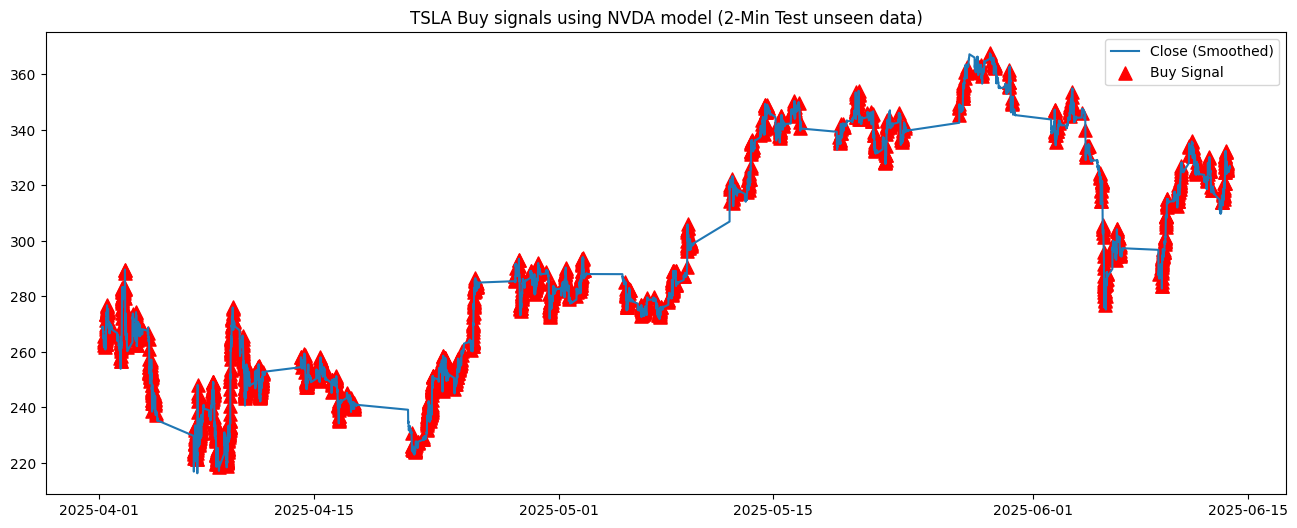

In [ ]:
print("Total Buy Signals (2min):", result_df_2min['signal_2min'].sum())
plt.figure(figsize=(16,6))
plt.plot(result_df_2min['timestamp'], result_df_2min['close_smoothed'], label='Close (Smoothed)')
plt.scatter(
    result_df_2min.loc[result_df_2min['signal_2min']==1, 'timestamp'],
    result_df_2min.loc[result_df_2min['signal_2min']==1, 'close_smoothed'],
    color='red',
    marker='^',
    s=90,
    label='Buy Signal'
)
plt.legend()
plt.title('TSLA Buy signals using NVDA model (2-Min Test unseen data)')
plt.show()

In [ ]:
feat_2min['low_vol_flag'] = 0

# --- Step 1: Predict from both models ---
X_live_scaled = scaler.transform(feat[features_NVDA].values)
feat_2min_scaled = scaler.transform(feat_2min[features_NVDA].values)

# Create sequences
X_seq_1min = create_sequences(X_live_scaled, seq_len=SEQ_LEN)
X_seq_2min = create_sequences(feat_2min_scaled, seq_len=SEQ_LEN)

# Run predictions
probs_1min = model_1min.predict(X_seq_1min, verbose=0).flatten()
probs_2min = model_2min.predict(X_seq_2min, verbose=0).flatten()

# Create 2-min sequence and predict
X_seq_2min = create_sequences(feat_2min_scaled, seq_len=SEQ_LEN)  # assuming already scaled
probs_2min = model_2min.predict(X_seq_2min, verbose=0).flatten()

# --- : Prepare timestamp columns (remove timezone) ---
feat['timestamp'] = feat['timestamp'].dt.tz_localize(None)
feat_2min['timestamp'] = feat_2min['timestamp'].dt.tz_localize(None)
bars['timestamp'] = bars['timestamp'].dt.tz_localize(None)

# --- : Align timestamps with prediction outputs ---
timestamps_1min = feat['timestamp'].iloc[-len(probs_1min):].reset_index(drop=True)
timestamps_2min = feat_2min['timestamp'].iloc[-len(probs_2min):].reset_index(drop=True)

# ---  Create DataFrames for model predictions ---
df_probs_1min = pd.DataFrame({
    'timestamp': timestamps_1min,
    'probs_1min': probs_1min
})
df_probs_2min = pd.DataFrame({
    'timestamp': timestamps_2min,
    'probs_2min': probs_2min
})

# ---  Merge probabilities and generate hybrid signal ---
df_merged = pd.merge(df_probs_1min, df_probs_2min, on='timestamp', how='inner')
df_merged['hybrid_prob'] = 0.6 * df_merged['probs_1min'] + 0.4 * df_merged['probs_2min']
df_merged['hybrid_signal'] = (df_merged['hybrid_prob'] > 0.6).astype(int)

# ---  Merge hybrid signals with NVDA price data ---
plot_price_signals = pd.merge(
    bars[['timestamp', 'close']].copy(),
    df_merged[['timestamp', 'hybrid_signal']].copy(),
    on='timestamp',
    how='inner'
)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


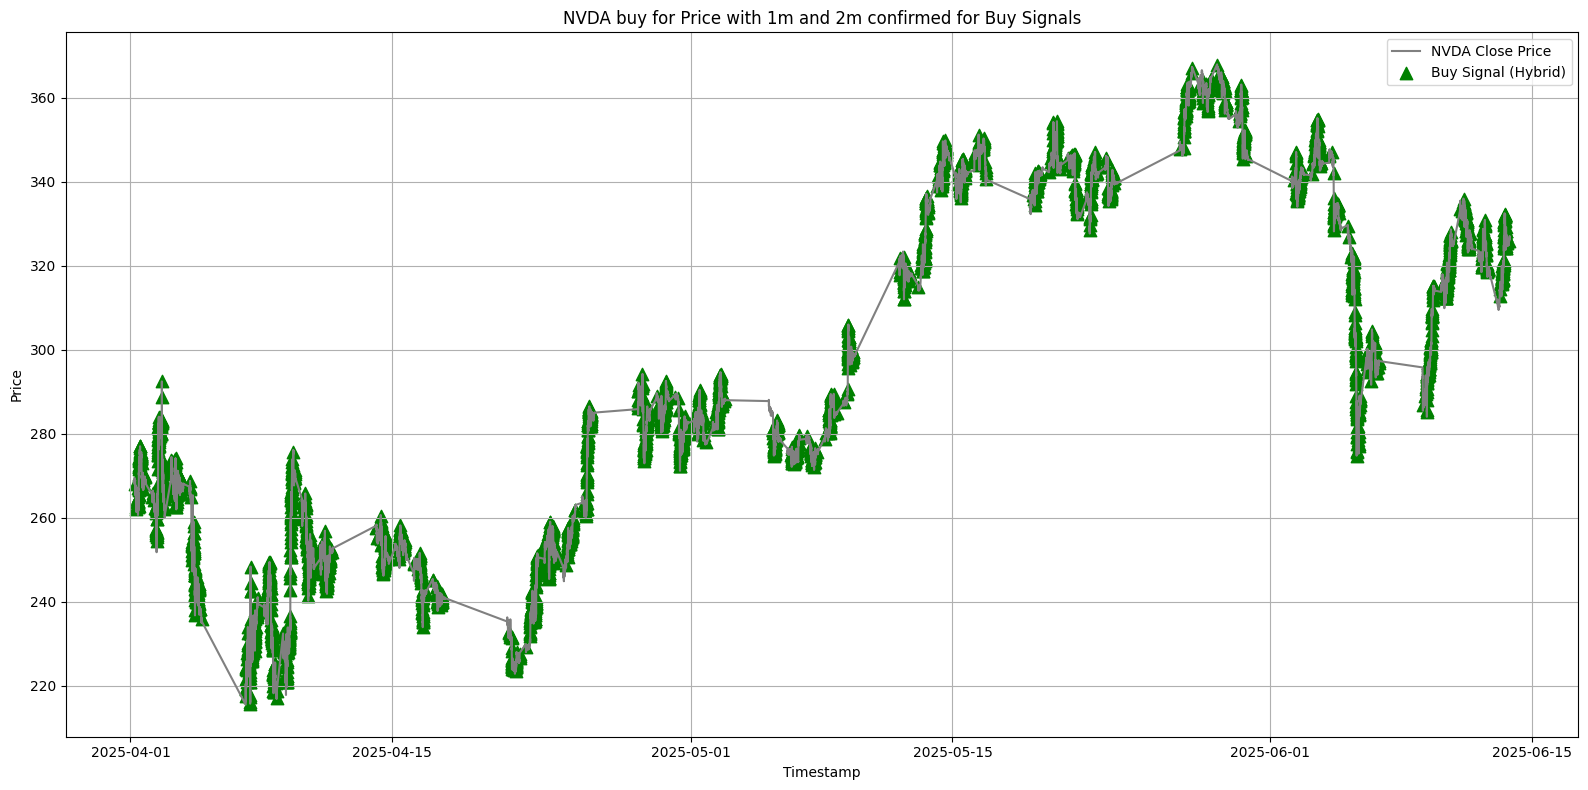

Total Buy Signals for TSLA using NVDA model (Hybrid): 4597


In [ ]:
# --- Get buy signals only ---
buy_signals = plot_price_signals[plot_price_signals['hybrid_signal'] == 1]

# --- Plot: Final Output Style ---
plt.figure(figsize=(16, 8))
plt.plot(plot_price_signals['timestamp'], plot_price_signals['close'], label='NVDA Close Price', color='gray')
plt.scatter(
    buy_signals['timestamp'],
    buy_signals['close'],
    color='green',
    marker='^',
    s=80,
    label='Buy Signal (Hybrid)'
)

plt.title("NVDA buy for Price with 1m and 2m confirmed for Buy Signals")
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Print how many signals occurred
print("Total Buy Signals for TSLA using NVDA model (Hybrid):", buy_signals.shape[0])

In [ ]:
initial_capital = 10000
capital = initial_capital
equity_curve = []
positions = []
in_trade = False
entry_price = None
entry_time = None

In [ ]:
# Merge price into df_merged for backtest use
df_merged = pd.merge(df_merged, bars[['timestamp', 'close']].copy(), on='timestamp', how='inner')

max_hold_bars = 60
entry_index = None

# Simulate trades
for i in range(len(df_merged)):
    row = df_merged.iloc[i]
    price = row['close']
    signal = row['hybrid_signal']

    if not in_trade and signal == 1:
        # --- Enter a trade ---
        entry_price = price
        entry_time = row['timestamp']
        entry_index = i               # << track index where trade started
        in_trade = True

    elif in_trade:
        ret = (price - entry_price) / entry_price

        # --- Exit on profit/loss ---
        if ret >= 0.05 or ret <= -0.05:
            pnl = capital * ret
            capital += pnl
            positions.append({
                'entry_time': entry_time,
                'exit_time': row['timestamp'],
                'entry_price': entry_price,
                'exit_price': price,
                'pnl': pnl,
                'return': ret
            })
            in_trade = False
            entry_price = None
            entry_time = None
            entry_index = None

        # --- Exit if held too long ---
        elif i - entry_index >= max_hold_bars:
            pnl = capital * ret
            capital += pnl
            positions.append({
                'entry_time': entry_time,
                'exit_time': row['timestamp'],
                'entry_price': entry_price,
                'exit_price': price,
                'pnl': pnl,
                'return': ret
            })
            in_trade = False
            entry_price = None
            entry_time = None
            entry_index = None

    # Always update equity
    equity_curve.append(capital)

In [ ]:
# --- Results to DataFrames ---
df_equity = pd.DataFrame({
    'timestamp': df_merged['timestamp'].iloc[:len(equity_curve)],
    'equity': equity_curve
})

df_trades = pd.DataFrame(positions)

Initial Capital:   $10000.00
Final Capital:     $13010.27
Total Trades:      315
Avg Return/Trade:  0.10%
Win Rate:          49.21%


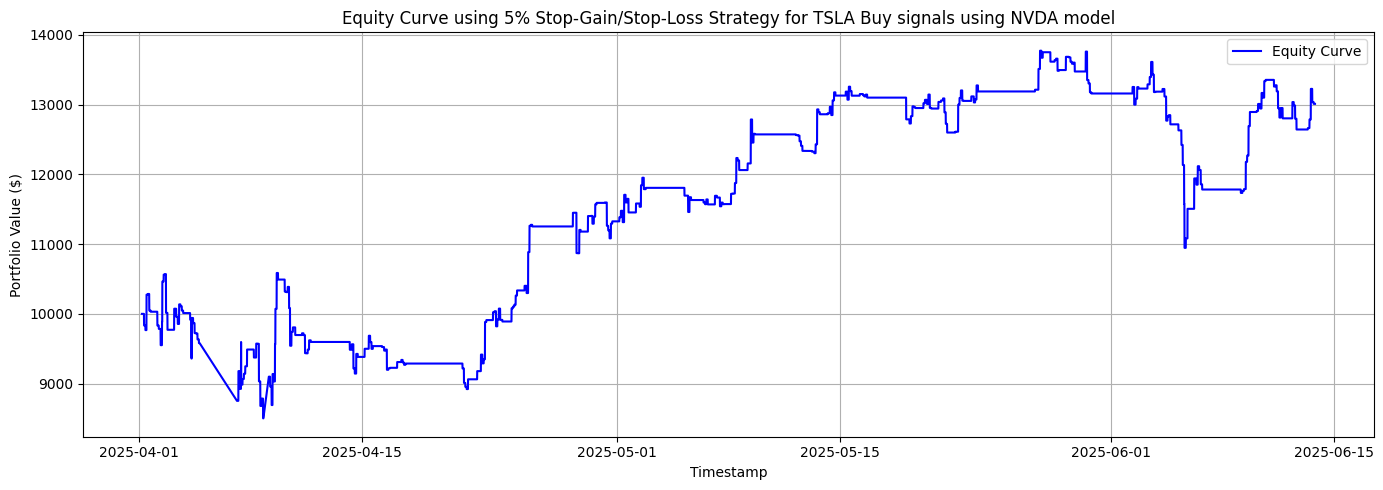

In [ ]:
# --- Summary Stats ---
print(f"Initial Capital:   ${initial_capital:.2f}")
print(f"Final Capital:     ${capital:.2f}")
print(f"Total Trades:      {len(df_trades)}")
if not df_trades.empty:
    print(f"Avg Return/Trade:  {df_trades['return'].mean() * 100:.2f}%")
    print(f"Win Rate:          {(df_trades['return'] > 0).mean() * 100:.2f}%")
else:
    print("  No trades executed.")

# --- Plot Equity Curve ---
plt.figure(figsize=(14, 5))
plt.plot(df_equity['timestamp'], df_equity['equity'], label='Equity Curve', color='blue')
plt.title("Equity Curve using 5% Stop-Gain/Stop-Loss Strategy for TSLA Buy signals using NVDA model")
plt.xlabel("Timestamp")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'])
df_merged = df_merged.sort_values('timestamp').reset_index(drop=True)
df_merged.set_index('timestamp', inplace=True)

In [ ]:
# --- Buy & Hold Strategy ---
initial_capital = 10000
buy_and_hold = df_merged['close'] / df_merged['close'].iloc[0] * initial_capital

final_bnh_value = buy_and_hold.iloc[-1]
bnh_return_pct = (final_bnh_value / initial_capital - 1) * 100

# --- Buy & Hold Summary ---
print(f"[BUY & HOLD SUMMARY]")
print(f"Initial Capital:             ${initial_capital:.2f}")
print(f"Final Portfolio Value:       ${final_bnh_value:.2f}")
print(f"Total Return:                {bnh_return_pct:.2f}%")

[BUY & HOLD SUMMARY]
Initial Capital:             $10000.00
Final Portfolio Value:       $12133.98
Total Return:                21.34%


In [ ]:
# --- DCA Strategy (every Monday) ---
#dca_dates = df_merged[df_merged.index.weekday == 0].index
#weekly_investment = initial_capital / len(dca_dates)
#dca_units = 0
#dca_equity_curve = []

#for ts, row in df_merged.iterrows():
#    if ts in dca_dates:
#        dca_units += weekly_investment / row['close']
#    dca_equity_curve.append(dca_units * row['close'])

In [ ]:
# --- DCA Strategy (Fixed $500 Every Monday) ---
weekly_investment = 500
dca_units = 0
total_invested = 0
cash_left = initial_capital
dca_equity_curve = []
num_dca_trades = 0  # Counter for Mondays actually invested

# All Mondays in the dataset
dca_dates = df_merged[df_merged.index.weekday == 0].index

for ts, row in df_merged.iterrows():
    price = row['close']
    if ts in dca_dates and cash_left >= weekly_investment:
        units = weekly_investment / price
        dca_units += units
        total_invested += weekly_investment
        cash_left -= weekly_investment
        num_dca_trades += 1  # Track only if $500 was actually invested
    dca_equity_curve.append(dca_units * price)

# Final portfolio value
final_value = dca_equity_curve[-1]
total_return_pct = (final_value / total_invested - 1) * 100 if total_invested > 0 else 0

# --- DCA Summary ---
print(f"[DCA SUMMARY]")
print(f"Fixed Investment per Monday:  ${weekly_investment}")
print(f"Total Mondays Invested:       {num_dca_trades}")
print(f"Total Cash Deployed:          ${total_invested:.2f}")
print(f"Remaining Cash:               ${cash_left:.2f}")
print(f"Final Portfolio Value:        ${final_value:.2f}")
print(f"Total Return:                 {total_return_pct:.2f}%")


[DCA SUMMARY]
Fixed Investment per Monday:  $500
Total Mondays Invested:       20
Total Cash Deployed:          $10000.00
Remaining Cash:               $0.00
Final Portfolio Value:        $14928.67
Total Return:                 49.29%


In [ ]:
# --- Hybrid Signal Strategy (±5% exit rule) ---
capital = initial_capital
equity_curve = []
in_trade = False
entry_price = None

for i in range(len(df_merged)):
    row = df_merged.iloc[i]
    price = row['close']
    signal = row['hybrid_signal']

    if not in_trade and signal == 1:
        entry_price = price
        in_trade = True
    elif in_trade:
        change = (price - entry_price) / entry_price
        if change >= 0.05 or change <= -0.05:
            capital *= (1 + change)
            in_trade = False
    equity_curve.append(capital)

In [ ]:
# --- Combine into one DataFrame for plotting ---
df_compare = pd.DataFrame({
    'Buy & Hold': buy_and_hold,
    'DCA (Monday)': dca_equity_curve,
    'Signal Strategy': equity_curve
}, index=df_merged.index)

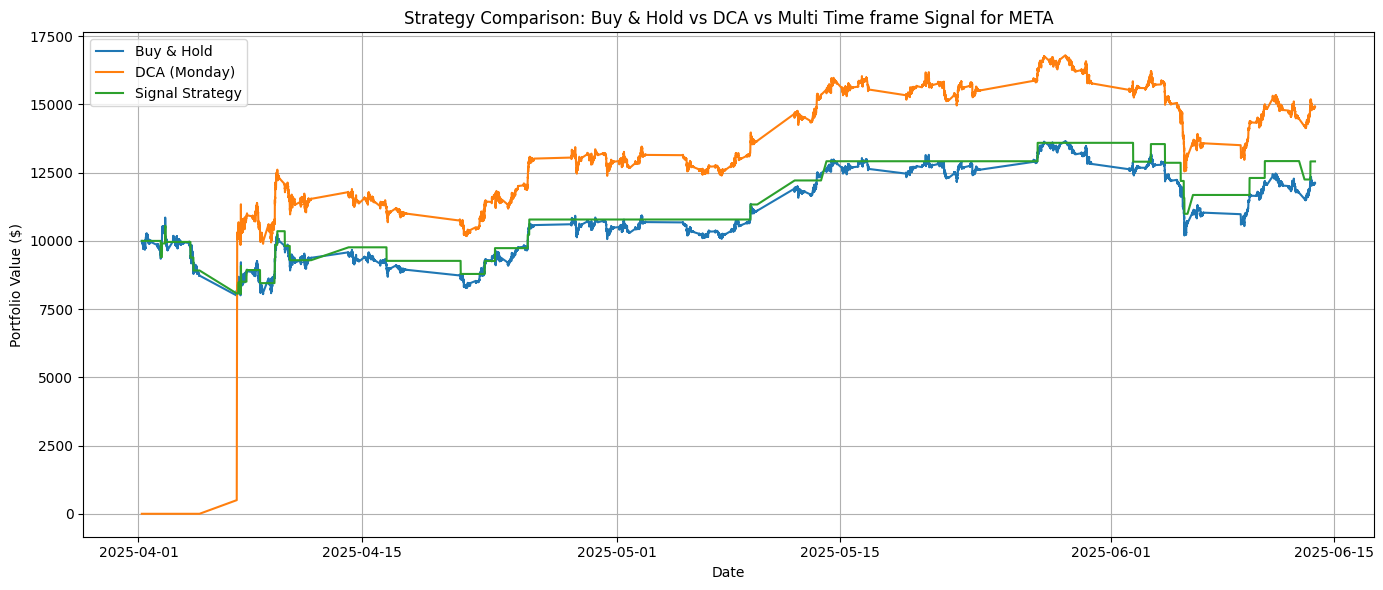

In [ ]:
# --- Plot the strategies ---
plt.figure(figsize=(14, 6))
plt.plot(df_compare, label=df_compare.columns)
plt.title("Strategy Comparison: Buy & Hold vs DCA vs Multi Time frame Signal for META")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# --- DCA Strategy (Fixed $500 Every Monday) ---
weekly_investment = 500
dca_units = 0
total_invested = 0
cash_left = initial_capital
dca_equity_curve = []

# All Mondays in the dataset
dca_dates = df_merged[df_merged.index.weekday == 0].index

for ts, row in df_merged.iterrows():
    price = row['close']
    if ts in dca_dates and cash_left >= weekly_investment:
        units = weekly_investment / price
        dca_units += units
        total_invested += weekly_investment
        cash_left -= weekly_investment
    dca_equity_curve.append(dca_units * price)

# Final portfolio value
final_value = dca_equity_curve[-1]
total_return_pct = (final_value / total_invested - 1) * 100 if total_invested > 0 else 0

# --- DCA Summary ---
print(f"[DCA SUMMARY]")
print(f"Fixed Investment per Monday:  ${weekly_investment}")
print(f"Total Mondays Invested:       {len([d for d in dca_dates if d <= df_merged.index[-1]])}")
print(f"Total Cash Deployed:          ${total_invested:.2f}")
print(f"Remaining Cash:               ${cash_left:.2f}")
print(f"Final Portfolio Value:        ${final_value:.2f}")
print(f"Total Return:                 {total_return_pct:.2f}%")


[DCA SUMMARY]
Fixed Investment per Monday:  $500
Total Mondays Invested:       4301
Total Cash Deployed:          $10000.00
Remaining Cash:               $0.00
Final Portfolio Value:        $14928.67
Total Return:                 49.29%


In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Sample input sequences (assumes shape: [samples, seq_len, num_features])
X_sample = X_seq_1min[:50]

# Flatten 3D LSTM input to 2D (required by KernelExplainer)
X_flat = X_sample.reshape(X_sample.shape[0], -1)  # shape: (50, seq_len * num_features)

#Model wrapper that reshapes input back for prediction
def model_flat(x):
    return model_1min.predict(x.reshape((-1, X_sample.shape[1], X_sample.shape[2])))


In [ ]:
# Run KernelExplainer
explainer = shap.KernelExplainer(model_flat, X_flat)
shap_values = explainer.shap_values(X_flat[:10])  # conservative slice

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4119/4119 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4119/4119 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4119/4119 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4119/4119 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4119/4119 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4119/4119 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4119/4119 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4119/4119 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4119/4119 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4119/4119 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step


In [ ]:
##Reshape SHAP output back to (samples, seq_len, features)
shap_matrix = np.array(shap_values)
shap_matrix = shap_matrix.reshape(10, X_sample.shape[1], X_sample.shape[2])


In [ ]:
shap_flat = np.mean(shap_matrix, axis=1)

In [ ]:
print("Used in SHAP:", shap_flat.shape[1])
print("Trained with:", len(features))

Used in SHAP: 13
Trained with: 13


In [ ]:
features = [
    'close_smoothed', 'volume', 'trade_count', 'price_change_smoothed',
    'volume_change', 'weak_momentum', 'vwap_spread', 'vwap_above_flag',
    'trade_per_volume', 'High_buy_flag', 'High_sell_flag',
    'egarch_vol', 'low_vol_flag'
]

In [ ]:
print("Available input features:", feat.columns.tolist())
print("Used feature list (features):", features)

Available input features: ['timestamp', 'close', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap', 'close_smoothed', 'price_change_smoothed', 'volume_change', 'vwap_spread', 'vwap_above_flag', 'trade_per_volume', 'High_buy_flag', 'High_sell_flag', 'weak_momentum', 'egarch_vol', 'low_vol_flag']
Used feature list (features): ['close_smoothed', 'volume', 'trade_count', 'price_change_smoothed', 'volume_change', 'weak_momentum', 'vwap_spread', 'vwap_above_flag', 'trade_per_volume', 'High_buy_flag', 'High_sell_flag', 'egarch_vol', 'low_vol_flag']


In [ ]:
# Check what's in feat but not in your feature list
missing = [f for f in feat.columns if f in features or 'timestamp' in f]
print("Likely missing feature:", [f for f in feat.columns if f not in missing])


Likely missing feature: ['close', 'high', 'low', 'open', 'vwap']


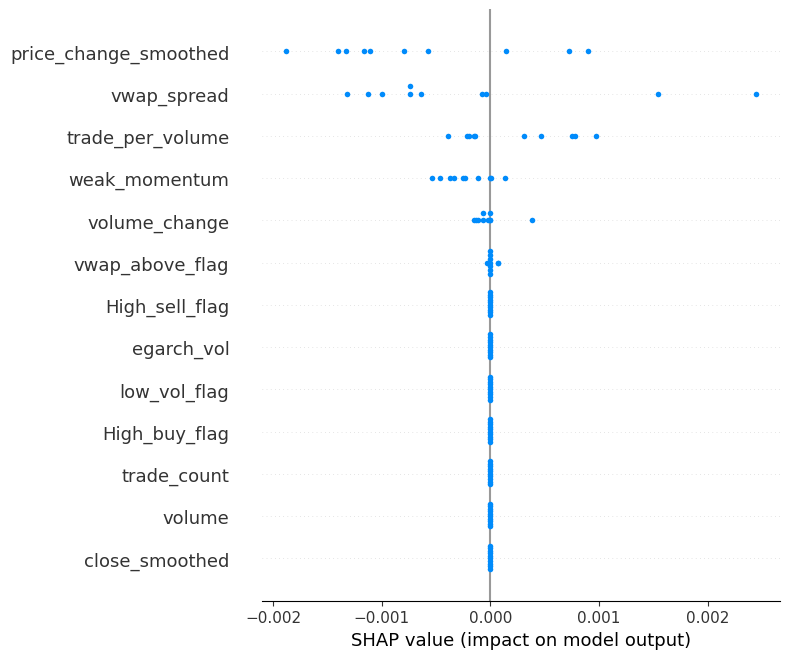

In [ ]:
shap.summary_plot(shap_flat, features[:13], plot_type="dot")

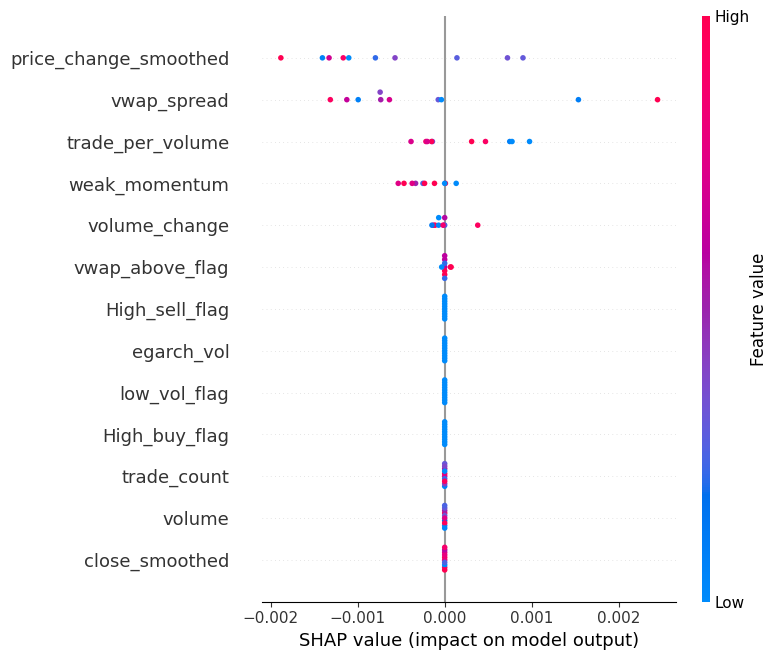

In [ ]:
# Step 1: Use only the first 10 samples (to match shap_flat)
X_display = X_flat[:10]  # shape = (10, 390)

# Step 2: Convert to (samples, features) to match shap_flat
X_display = X_display.reshape((10, 30, 13)).mean(axis=1)  # shape = (10, 13)

# Step 3: Plot with feature values (color) included
shap.summary_plot(shap_flat, X_display, feature_names=features[:13], plot_type="dot")
